In [10]:

from IntelliMaint.eda import ExploratoryAnalysis
from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.data_acquistion import DataAcquisition
from IntelliMaint.preprocessing import DataPreprocessing
from IntelliMaint.data_analysis import SOM 
from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.rul_models import GPRDegradationModel
from IntelliMaint.health_assessment import HealthIndicator

import sys
sys.path.append(r'C:\Users\DELL\Desktop\Template\Intellimaint')

from data_acquistion import DataAcquisition

#from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.anomaly_detection import AnomalyDetection
#from IntelliMaint.data_analysis import SOM
#from IntelliMaint.rul_models import GPRDegradationModel


import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, savgol_filter, hilbert
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker


import pickle as pkl
from imblearn.over_sampling import SMOTE

In [33]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, savgol_filter, hilbert
from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker

import sys
sys.path.append(r'C:\Users\DELL\Desktop\Template\Intellimaint')

from data_acquistion import DataAcquisition

data_dir_path = r'C:\Users\DELL\Desktop\Template\data\1st_test\1st_test/'

# Get data from the directory
data_acquistion = DataAcquisition()
df = data_acquistion.get_data_from_dir(data_dir_path)

# Get list of files
#files = data_acquistion.get_file_list(DATA_DIR_PATH)  #get_file_list not present
#files = data_acquistion.get_file_list(data_dir_path)

print(len(files))

Bd = 0.331  # ball diameter, in inches
Pd = 2.815  # pitch diameter, in inches
Nb = 16  # number of rolling elements
a = 15.17 * math.pi / 180  # contact angle, in radians
s = 2000 / 60  # rotational frequency, in Hz

ratio = Bd / Pd * math.cos(a)
ftf = s / 2 * (1 - ratio)
bpfi = Nb / 2 * s * (1 + ratio)
bpfo = Nb / 2 * s * (1 - ratio)
bsf = Pd / Bd * s / 2 * (1 - ratio**2)
bearFreq = [ftf, bpfi, bpfo, bsf]
sampRate = 20480  # Sampling rate, in Hz
##############################################

bearing = Bearing(files, Bd, Pd, Nb, a, s, sampRate)

###################################
# Analyze raw vibration data
ber = 4
bearing.analyze_raw_data(ber)

class Bearing: #model of bearing done from bearing diag
    def __init__(self, files, Bd, Pd, Nb, a, s, sampRate):
        self.files = files
        self.Bd = Bd
        self.Pd = Pd
        self.Nb = Nb
        self.a = a
        self.s = s
        self.sampRate = sampRate
        self.ratio = self.Bd / self.Pd * math.cos(self.a)
        self.ftf = self.s / 2 * (1 - self.ratio)
        self.bpfi = self.Nb / 2 * self.s * (1 + self.ratio)
        self.bpfo = self.Nb / 2 * self.s * (1 - self.ratio)
        self.bsf = self.Pd / self.Bd * self.s / 2 * (1 - self.ratio**2)
        self.bearFreq = [self.ftf, self.bpfi, self.bpfo, self.bsf]

    def analyze_raw_data(self, ber):
        for Col in range(self.num_Columns):
            signal = pd.to_numeric(df.iloc[:, ber], errors='coerce').dropna().values
        #rawData = pd.read_csv(self.files[0], sep='\t', header=None)
        #signal = df.iloc[:, ber].values

        # Split the signal into normal and outer_fault portions
            normal_signal = signal[:750]
            outer_fault_signal = signal[750:]

            # Plot the normal and outer race fault signals
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(normal_signal)
            plt.title('Normal Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            plt.subplot(2, 2, 2)
            plt.plot(outer_fault_signal)
            plt.title('Outer Race Fault Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

        # Perform FFT on the normal and outer race fault signals
            normal_fft = np.abs(fft(normal_signal))
            outer_fault_fft = np.abs(fft(outer_fault_signal))
    
            freq_normal = np.fft.fftfreq(len(normal_signal), 1/self.sampRate)
            freq_outer_fault = np.fft.fftfreq(len(outer_fault_signal), 1/self.sampRate)
    
            # Plot the FFT of the normal signal
            plt.subplot(2, 2, 3)
            plt.plot(freq_normal[:len(freq_normal)//2], normal_fft[:len(normal_fft)//2])
            plt.title('FFT of Normal Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed
    
            # Plot the FFT of the outer race fault signal
            plt.subplot(2, 2, 4)
            plt.plot(freq_outer_fault[:len(freq_outer_fault)//2], outer_fault_fft[:len(outer_fault_fft)//2])
            plt.title('FFT of Outer Race Fault Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed
    
            # Add vertical lines for BPFO harmonics in the outer race fault FFT plot
            num_harmonics = 4  # Number of harmonics to plot
            for i in range(1, num_harmonics + 1):
                harmonic_freq = i * self.bpfo
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', linewidth=1, label=f'{i}x BPFO' if i == 1 else '')
                plt.text(harmonic_freq, plt.ylim()[1] * 0.9, f'{i}x BPFO\n{harmonic_freq:.2f} Hz', rotation=90, va='top', ha='right', fontsize=8)
    
            plt.tight_layout()
            plt.show()
            

data dir path : C:\Users\DELL\Desktop\Template\data\1st_test\1st_test/
length of files :  2156


KeyboardInterrupt: 

In [6]:
import os
print(os.getcwd())



C:\Users\DELL\Desktop\Template


----
Found 984 files in the directory.
Total files found: 984


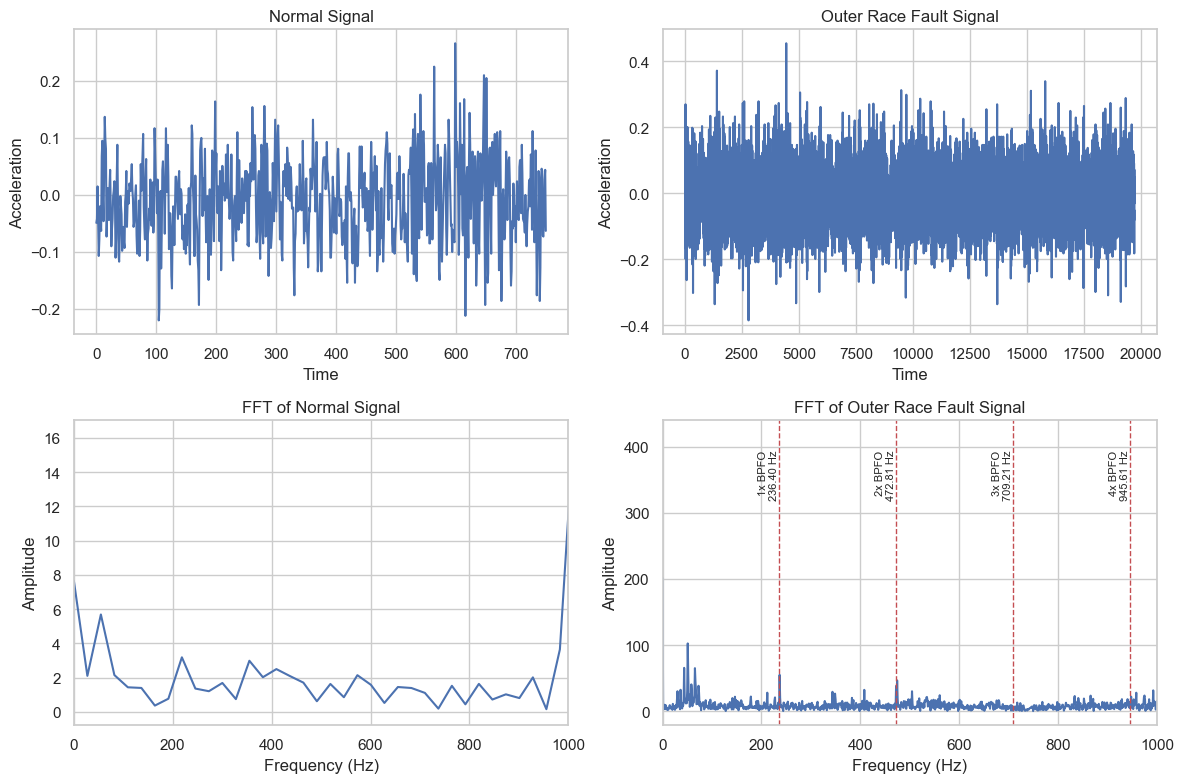

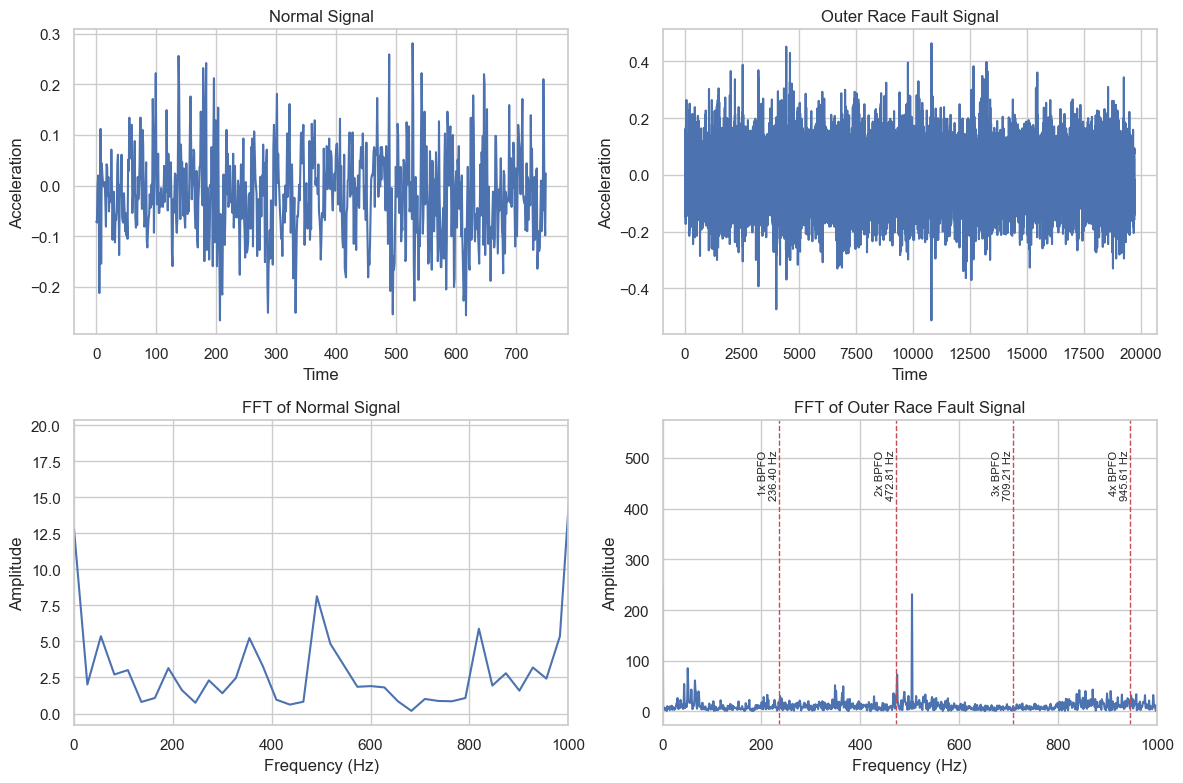

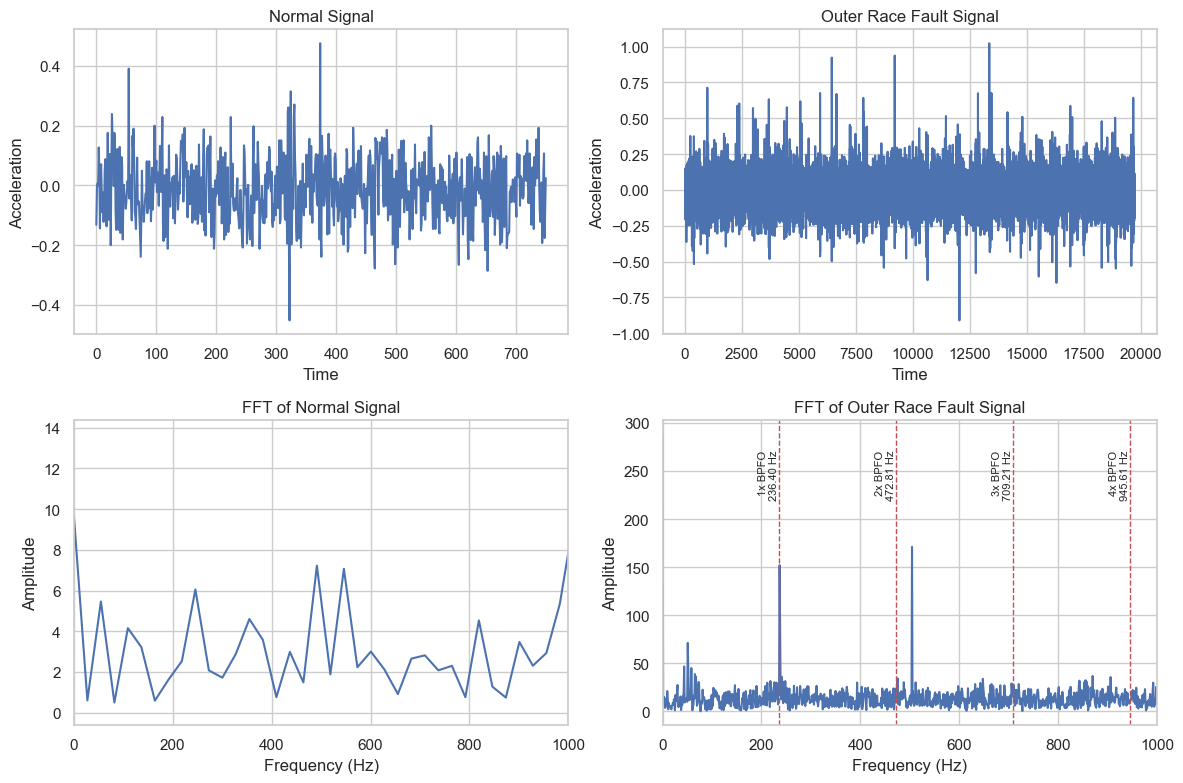

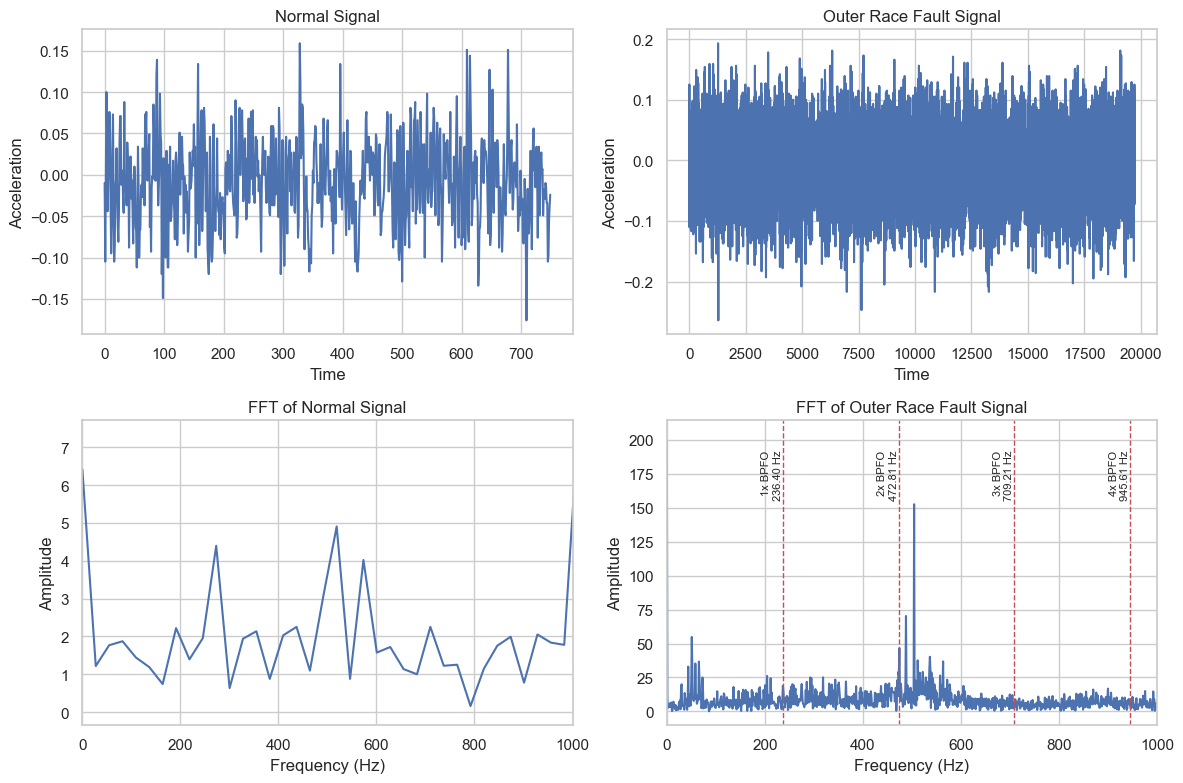

data dir path : C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/
length of files :  984
Reading file 1 of 984
Reading file 2 of 984
Reading file 3 of 984
Reading file 4 of 984
Reading file 5 of 984
Reading file 6 of 984
Reading file 7 of 984
Reading file 8 of 984
Reading file 9 of 984
Reading file 10 of 984
Reading file 11 of 984
Reading file 12 of 984
Reading file 13 of 984
Reading file 14 of 984
Reading file 15 of 984
Reading file 16 of 984
Reading file 17 of 984
Reading file 18 of 984
Reading file 19 of 984
Reading file 20 of 984
Reading file 21 of 984
Reading file 22 of 984
Reading file 23 of 984
Reading file 24 of 984
Reading file 25 of 984
Reading file 26 of 984
Reading file 27 of 984
Reading file 28 of 984
Reading file 29 of 984
Reading file 30 of 984
Reading file 31 of 984
Reading file 32 of 984
Reading file 33 of 984
Reading file 34 of 984
Reading file 35 of 984
Reading file 36 of 984
Reading file 37 of 984
Reading file 38 of 984
Reading file 39 of 984
Reading file 40 of

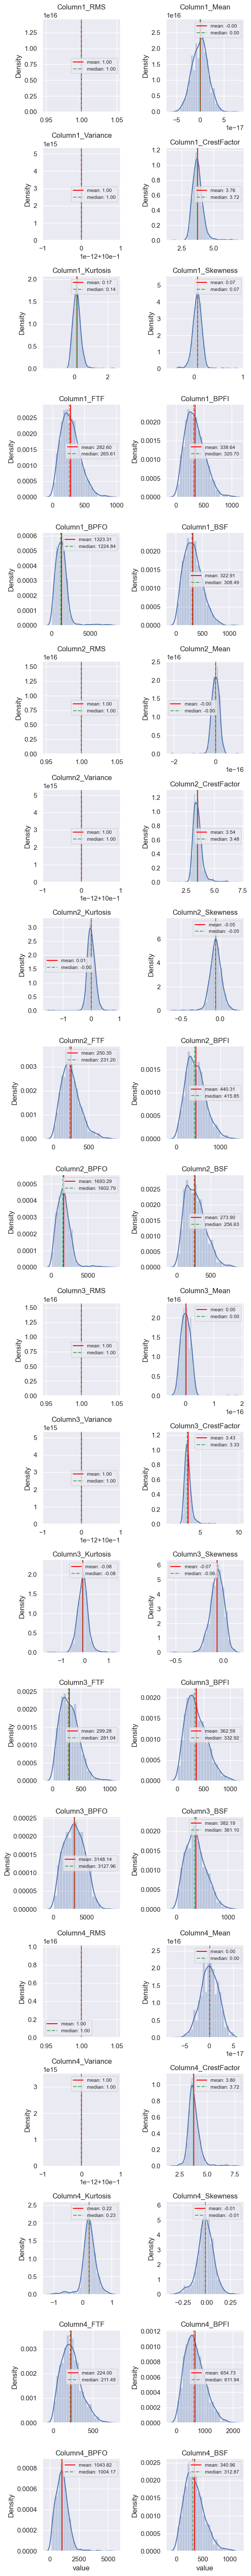

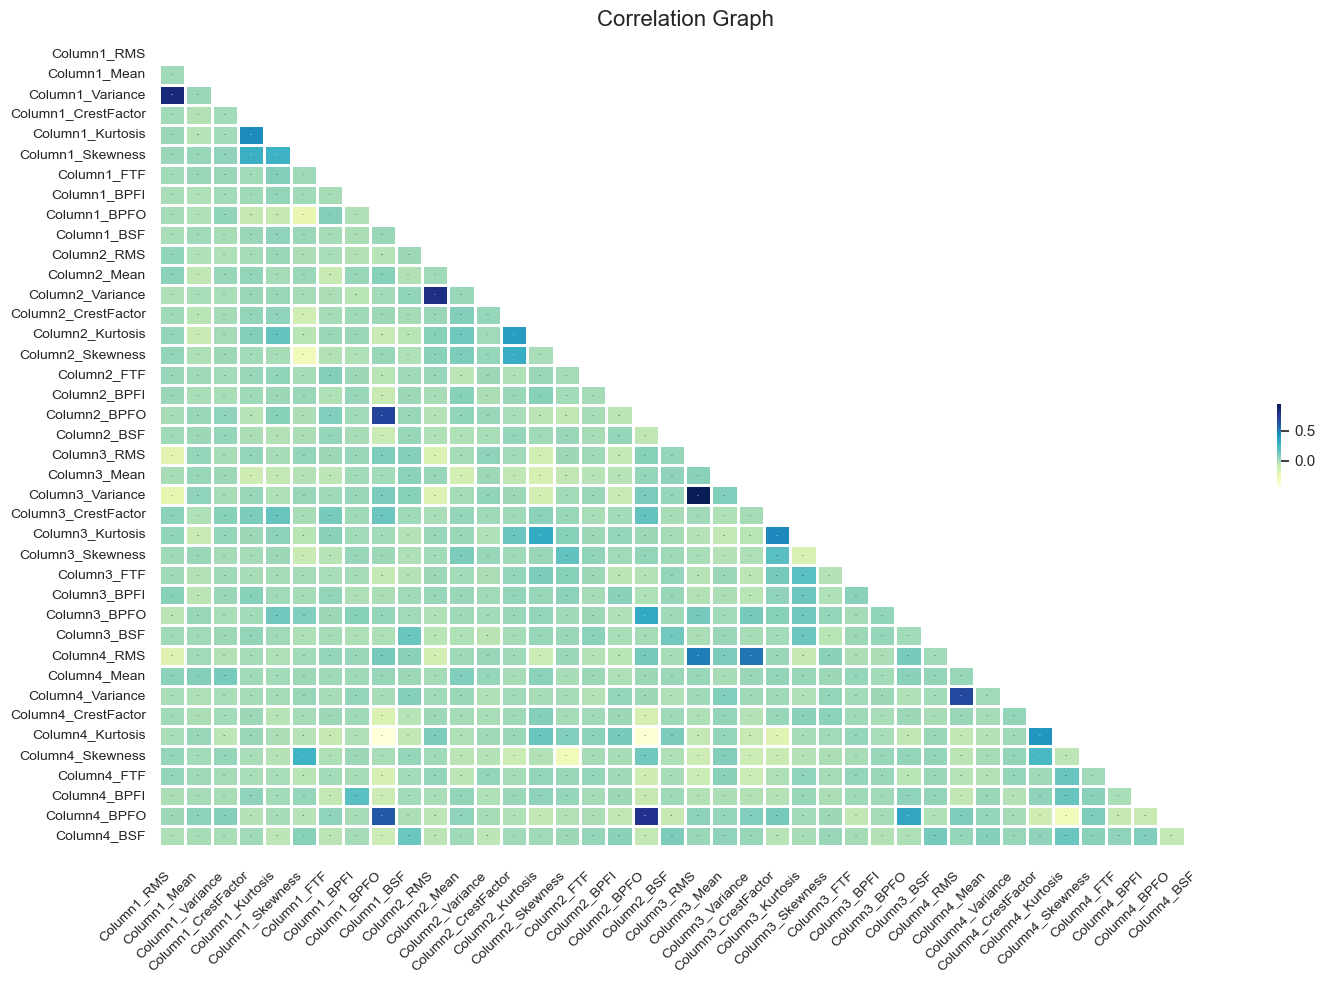

In [1]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.signal import butter, lfilter, savgol_filter, hilbert
#from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker
#from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.feature_engineering import FrequencyDomain
from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.data_analysis import SOM
from IntelliMaint.rul_models import GPRDegradationModel
from IntelliMaint.preprocessing import DataPreprocessing
from IntelliMaint.eda import ExploratoryAnalysis

import pickle as pkl
from imblearn.over_sampling import SMOTE

import sys
sys.path.insert(0, r'C:\Users\DELL\Desktop\Template\IntelliMaint')

from data_acquistion import DataAcquisition
from feature_engineering import TimeDomain, FrequencyDomain



class Bearing: #model of bearing done from bearing diag
    def __init__(self, files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols):
        self.files = files
        self.Bd = Bd
        self.Pd = Pd
        self.Nb = Nb
        self.a = a
        self.s = s
        self.sampRate = sampRate
        self.ratio = self.Bd / self.Pd * math.cos(self.a)
        self.ftf = self.s / 2 * (1 - self.ratio)
        self.bpfi = self.Nb / 2 * self.s * (1 + self.ratio)
        self.bpfo = self.Nb / 2 * self.s * (1 - self.ratio)
        self.bsf = self.Pd / self.Bd * self.s / 2 * (1 - self.ratio**2)
        self.bearFreq = [self.ftf, self.bpfi, self.bpfo, self.bsf]
        self.ber = ber
        self.n_cols = n_cols

    def analyze_raw_data(self, n_cols):
        rawData = pd.read_csv(self.files[0], sep='\t', header=None)
        
        for Col in range(self.n_cols):
            signal = rawData.iloc[:, Col].values

            # Split the signal into normal and outer_fault portions
            normal_signal = signal[:750]
            outer_fault_signal = signal[750:]

            # Plot the normal and outer race fault signals
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(normal_signal)
            plt.title('Normal Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            plt.subplot(2, 2, 2)
            plt.plot(outer_fault_signal)
            plt.title('Outer Race Fault Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            # Perform FFT on the normal and outer race fault signals
            normal_fft = np.abs(fft(normal_signal))
            outer_fault_fft = np.abs(fft(outer_fault_signal))
    
            freq_normal = np.fft.fftfreq(len(normal_signal), 1/self.sampRate)
            freq_outer_fault = np.fft.fftfreq(len(outer_fault_signal), 1/self.sampRate)
    
            # Plot the FFT of the normal signal
            plt.subplot(2, 2, 3)
            plt.plot(freq_normal[:len(freq_normal)//2], normal_fft[:len(normal_fft)//2])
            plt.title('FFT of Normal Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Plot the FFT of the outer race fault signal
            plt.subplot(2, 2, 4)
            plt.plot(freq_outer_fault[:len(freq_outer_fault)//2], outer_fault_fft[:len(outer_fault_fft)//2])
            plt.title('FFT of Outer Race Fault Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Add vertical lines for BPFO harmonics in the outer race fault FFT plot
            num_harmonics = 4  # Number of harmonics to plot
            for i in range(1, num_harmonics + 1):
                harmonic_freq = i * self.bpfo
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', linewidth=1, label=f'{i}x BPFO' if i == 1 else '')
                plt.text(harmonic_freq, plt.ylim()[1] * 0.9, f'{i}x BPFO\n{harmonic_freq:.2f} Hz', rotation=90, va='top', ha='right', fontsize=8)
    
            plt.tight_layout()
            plt.show()


    #def extract_time_domain_features(self, signal):
        #kurtosis_val = kurtosis(signal)
        #skewness_val = skew(signal)
        
        # Return kurtosis and skewness as the time-domain features
        #return [kurtosis_val, skewness_val]
        #features = TimeDomain.extract_features_streaming(pd.Series(signal))
        #return features

    #def extract_fft(self, signal):
        #return FrequencyDomain.extract_fft(signal)

    #def extract_domain_features(self, xf, amps):
        # Extract FTF, BPFI, BPFO, BSF as domain features
        #return FrequencyDomain.extract_domain_features(xf, amps)

    def extract_features(self, preprocessed_signal):
        # Extract time-domain features
        time_features = TimeDomain.extract_features_streaming(pd.Series(preprocessed_signal))

        # Extract FFT domain features
        fd = FrequencyDomain(self.sampRate, self.ftf, self.bpfi, self.bpfo, self.bsf, preprocessed_signal)
        domain_features = fd.extract_features(preprocessed_signal)

        # Convert time_features and domain_features to tuples
        time_features = tuple(time_features)
        domain_features = tuple(domain_features)

        # Return the combined features
        return time_features + domain_features


# Get data from the directory
data_dir_path = r'C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/'
data_acquisition = DataAcquisition()


# Get list of files
files = DataAcquisition.get_file_list(data_dir_path)
print(f"Total files found: {len(files)}")

# Get list of files
# Call the class method directly on the class, not the object
#files = DataAcquisition.get_file_list(data_dir_path)

#files = data_acquistion.get_file_list()
#print(len(files))
#print("---")


# Get all CSV files from the folder
#files = sorted(glob.glob(folder_path + '200*'))  # Sort files to ensure chronological order

#folder_path = r'C:\Users\DELL\Desktop\Navtat\inteliMaint-main\inteliMaint-main\examples\data\2nd_test\2nd_test/'
#print(folder_path)
#files = glob.glob(folder_path + '200*')[:]
#print(len(files))

############################################
Bd = 0.331  # ball diameter, in inches
Pd = 2.815  # pitch diameter, in inches
Nb = 16  # number of rolling elements
a = 15.17 * math.pi / 180  # contact angle, in radians
s = 2000 / 60  # rotational frequency, in Hz
ber = 0 #Can add ber to get raw_data plot for all ber
n_cols = 4


ratio = Bd / Pd * math.cos(a)
ftf = s / 2 * (1 - ratio)
bpfi = Nb / 2 * s * (1 + ratio)
bpfo = Nb / 2 * s * (1 - ratio)
bsf = Pd / Bd * s / 2 * (1 - ratio**2)
bearFreq = [ftf, bpfi, bpfo, bsf]
sampRate = 20480  # Sampling rate, in Hz
##############################################

bearing = Bearing(files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols) #Can add ber to get raw_data plot for all ber

###################################
# Analyze raw vibration data
ber = 0
n_cols = 4
bearing.analyze_raw_data(ber)
##################################

# Initialize Preprocessing
preprocessing = DataPreprocessing()
df = data_acquisition.get_data_from_dir(data_dir_path)

# Lists to store all features and timestamps
all_features = []
all_timestamps = []

# Process each file
for file_path in files:
    df = DataAcquisition.get_data_from_file(file_path)
    file_features = []
    for Col in range(n_cols):  # Iterate through each column (sensor)
    #rawData = pd.read_csv(df.files[0], sep='\t', header=None)
        signal = pd.to_numeric(df.iloc[:, Col], errors= 'coerce').dropna().values
        signal = np.array(signal, dtype=float)  # Convert to numpy array
        preprocessed_signal = preprocessing.preprocess(signal, operations=['filter', 'smooth', 'normalize'])

    
    # Plot the preprocessed signal (after preprocessing)
    #plt.figure(figsize=(10, 4))
    #plt.plot(preprocessed_signal, label=f'Preprocessed Signal - Sensor {Col+1}', color='orange')
    #plt.title(f'Preprocessed Signal - Sensor {Col+1}')
    #plt.xlabel('Sample Index')
    #plt.ylabel('Amplitude')
    #plt.legend()
    #plt.show()

        features = bearing.extract_features(preprocessed_signal)
        file_features.extend(features)

    # Append features and timestamps
    all_features.append(file_features)


time_domain_columns = ['RMS', 'Mean', 'Variance', 'CrestFactor', 'Kurtosis', 'Skewness'] #to correct ValueError: 6 columns passed, passed data had 18 columns
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']
all_columns = time_domain_columns + domain_columns
num_features_per_column = len(time_domain_columns + domain_columns) #To verify not to get error in Number of column PASSED
sensor_columns = [f'Column{Col+1}_{feat}' for Col in range(n_cols) for feat in all_columns]
print(sensor_columns)  # Verify the number of columns
feature_df = pd.DataFrame(all_features, columns=sensor_columns)    

print("Feature DataFrame:\n", feature_df.head())

eda_results = ExploratoryAnalysis.perform_eda(feature_df)


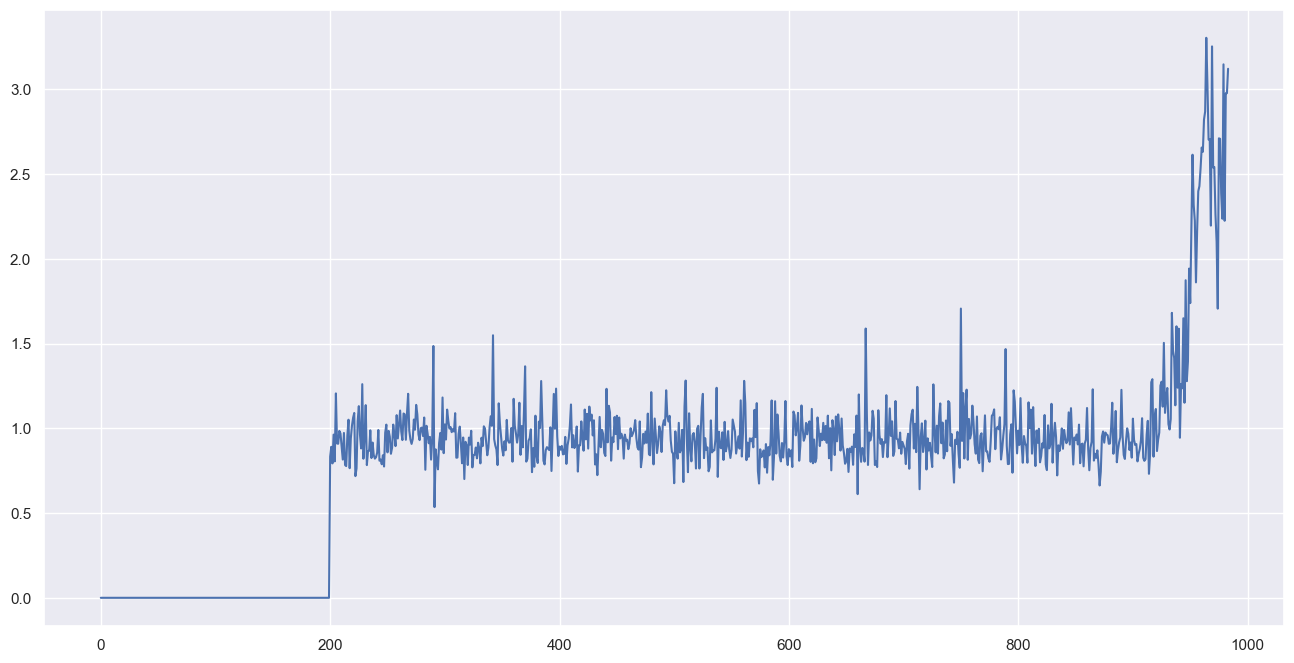

In [3]:
# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define time-domain and domain features for the first sensor (Column 1)
time_domain_columns_first_sensor = ['Kurtosis', 'Skewness']  # Only kurtosis and skewness for the first sensor
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']  # Domain features for the first sensor

# Combine time-domain and domain features for the first sensor only
all_columns = time_domain_columns_first_sensor + domain_columns

# Sensor column names for the first sensor (Column 1)
sensor_columns = [f'Column1_{feat}' for Col in range(n_cols) for feat in all_columns]

# Convert all_features list to NumPy array
all_features = np.array(all_features)  # Ensure it's a NumPy array to access .shape

# Check the shape of all_features
print("Shape of all_features array:", all_features.shape)

# Ensure the number of columns in all_features matches the length of sensor_columns (should be 6)
if all_features.shape[1] != len(sensor_columns):
    print(f"Error: Mismatch in number of features. Expected {len(sensor_columns)} features but got {all_features.shape[1]}")
else:
    # Create DataFrame for feature extraction
    feature_df = pd.DataFrame(all_features, columns=sensor_columns)
    print("Feature DataFrame:\n", feature_df.head())

    #########################################################
    # Construct Health Indicator with SOM for the first sensor
    normal_data_pts_som = 200  # Set a threshold for normal data points
    train_som = feature_df[:normal_data_pts_som]  # Training data for SOM (first 200 data points)
    test_som = feature_df  # Use the entire feature set for testing

    # Train SOM model
    data_analysis = SOM()
    som, scaler_ = data_analysis.train(train_som)

    # Predict MQE (Mean Quantization Error)
    mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

    # Plot the MQE values
    plt.figure(figsize=(16, 8))
    plt.plot(mqe)
    plt.title('MQE Plot for First Sensor with Time Domain (Kurtosis, Skewness) and Domain Features')
    plt.xlabel('Sample Number')
    plt.ylabel('MQE')
    plt.show()


Shape of all_features array: (984, 40)
Error: Mismatch in number of features. Expected 24 features but got 40


Shape of all_features array: (984, 40)
Shape of all_features_first_sensor array: (984, 6)
Feature DataFrame for First Sensor:
    Column1_Kurtosis  Column1_Skewness  Column1_FTF  Column1_BPFI  \
0               1.0      3.053113e-17          1.0      4.393638   
1               1.0     -2.498002e-17          1.0      3.798681   
2               1.0      8.673617e-18          1.0      3.524016   
3               1.0      1.110223e-17          1.0      3.662787   
4               1.0     -1.110223e-17          1.0      3.401584   

   Column1_BPFO  Column1_BSF  
0      0.395819     0.019838  
1      0.127659     0.108253  
2     -0.148658     0.016833  
3      0.094529     0.005519  
4     -0.076422     0.065502  


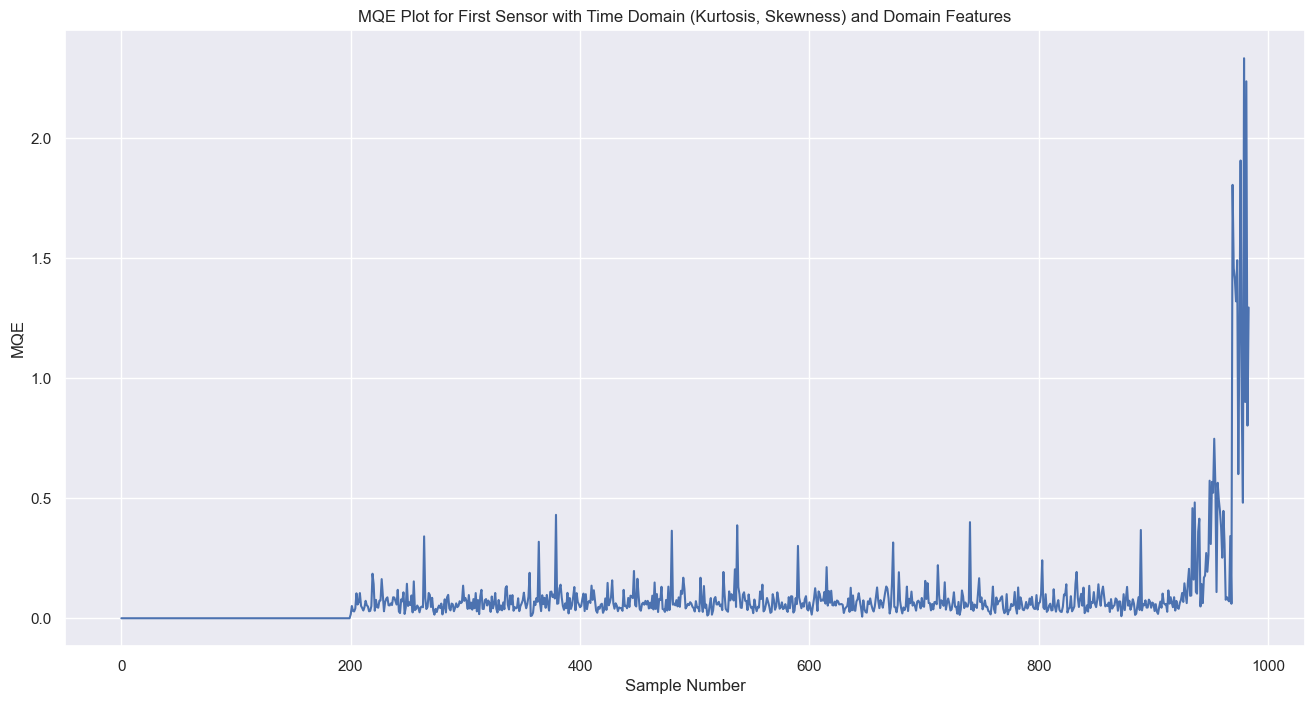

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define time-domain and domain features for the first sensor (Column 1)
time_domain_columns_first_sensor = ['Kurtosis', 'Skewness']  # Only kurtosis and skewness for the first sensor
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']  # Domain features for the first sensor

# Combine time-domain and domain features for the first sensor only
all_columns = time_domain_columns_first_sensor + domain_columns

# Sensor column names for the first sensor (Column 1)
sensor_columns = [f'Column1_{feat}' for feat in all_columns]

# Convert all_features list to NumPy array
all_features = np.array(all_features)  # Ensure it's a NumPy array to access .shape

# Check the shape of all_features
print("Shape of all_features array:", all_features.shape)

# Extract only the first 6 columns corresponding to the first sensor
all_features_first_sensor = all_features[:, :6]  # Slice the first 6 columns

# Check if we have the correct number of columns
print("Shape of all_features_first_sensor array:", all_features_first_sensor.shape)

# Create DataFrame for the first sensor's features
feature_df = pd.DataFrame(all_features_first_sensor, columns=sensor_columns)
print("Feature DataFrame for First Sensor:\n", feature_df.head())

#########################################################
# Construct Health Indicator with SOM for the first sensor
normal_data_pts_som = 200  # Set a threshold for normal data points
train_som = feature_df[:normal_data_pts_som]  # Training data for SOM (first 200 data points)
test_som = feature_df  # Use the entire feature set for testing

# Train SOM model
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)

# Predict MQE (Mean Quantization Error)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

# Plot the MQE values
plt.figure(figsize=(16, 8))
plt.plot(mqe)
plt.title('MQE Plot for First Sensor with Time Domain (Kurtosis, Skewness) and Domain Features')
plt.xlabel('Sample Number')
plt.ylabel('MQE')
plt.show()


In [17]:
import IntelliMaint.feature_engineering
print(IntelliMaint.feature_engineering.__file__)

'''
import numpy as np
from scipy.fft import fft, fftfreq

signal = np.random.random(1024)
N = len(signal)
yf = fft(signal)
xf = fftfreq(N, 1 / 1000)  # assuming a sample rate of 1000 Hz
print(xf, yf)
'''

from IntelliMaint.feature_engineering import FrequencyDomain

signal = np.random.random(1024)
fd = FrequencyDomain(sampRate=1000, ftf=30, bpfi=100, bpfo=150, bsf=200, data=signal)
xf, yf = fd.extract_fft(signal)
print(xf, yf)



C:\Users\DELL\Desktop\Template\IntelliMaint\feature_engineering.py
[  0.          0.9765625   1.953125    2.9296875   3.90625     4.8828125
   5.859375    6.8359375   7.8125      8.7890625   9.765625   10.7421875
  11.71875    12.6953125  13.671875   14.6484375  15.625      16.6015625
  17.578125   18.5546875  19.53125    20.5078125  21.484375   22.4609375
  23.4375     24.4140625  25.390625   26.3671875  27.34375    28.3203125
  29.296875   30.2734375  31.25       32.2265625  33.203125   34.1796875
  35.15625    36.1328125  37.109375   38.0859375  39.0625     40.0390625
  41.015625   41.9921875  42.96875    43.9453125  44.921875   45.8984375
  46.875      47.8515625  48.828125   49.8046875  50.78125    51.7578125
  52.734375   53.7109375  54.6875     55.6640625  56.640625   57.6171875
  58.59375    59.5703125  60.546875   61.5234375  62.5        63.4765625
  64.453125   65.4296875  66.40625    67.3828125  68.359375   69.3359375
  70.3125     71.2890625  72.265625   73.2421875  74.2187

----
Found 984 files in the directory.
Total files found: 984


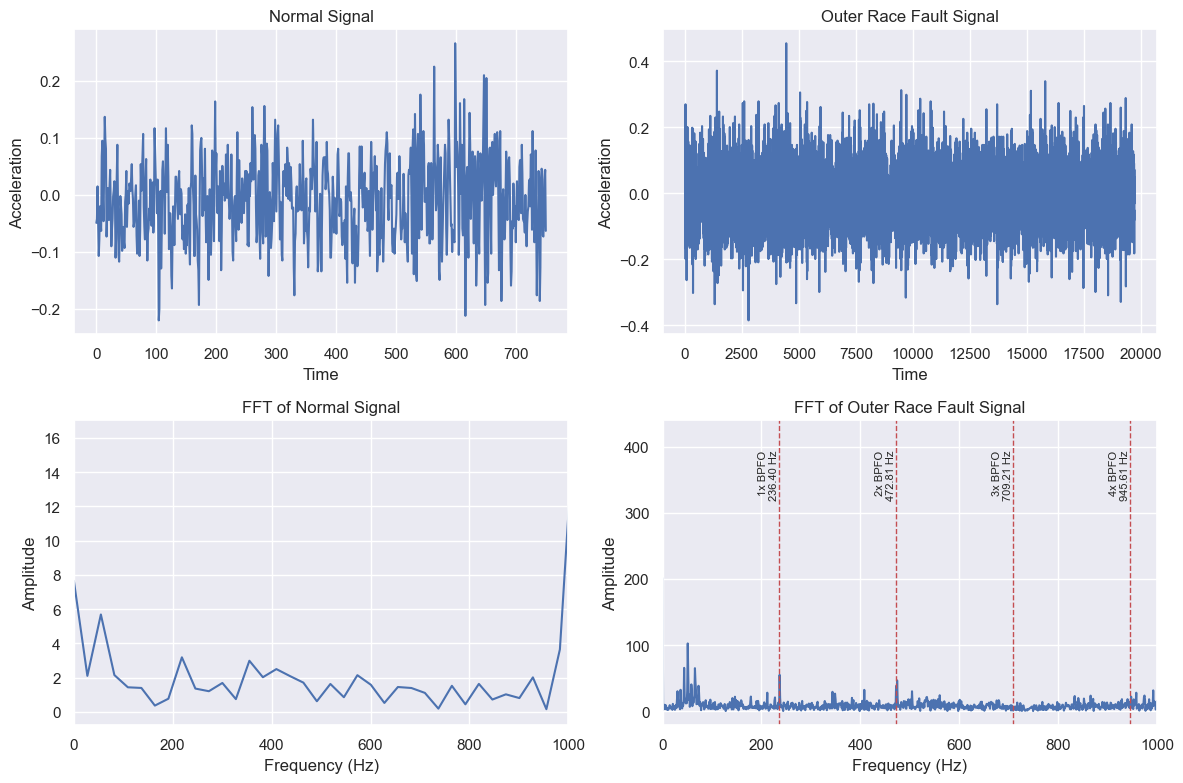

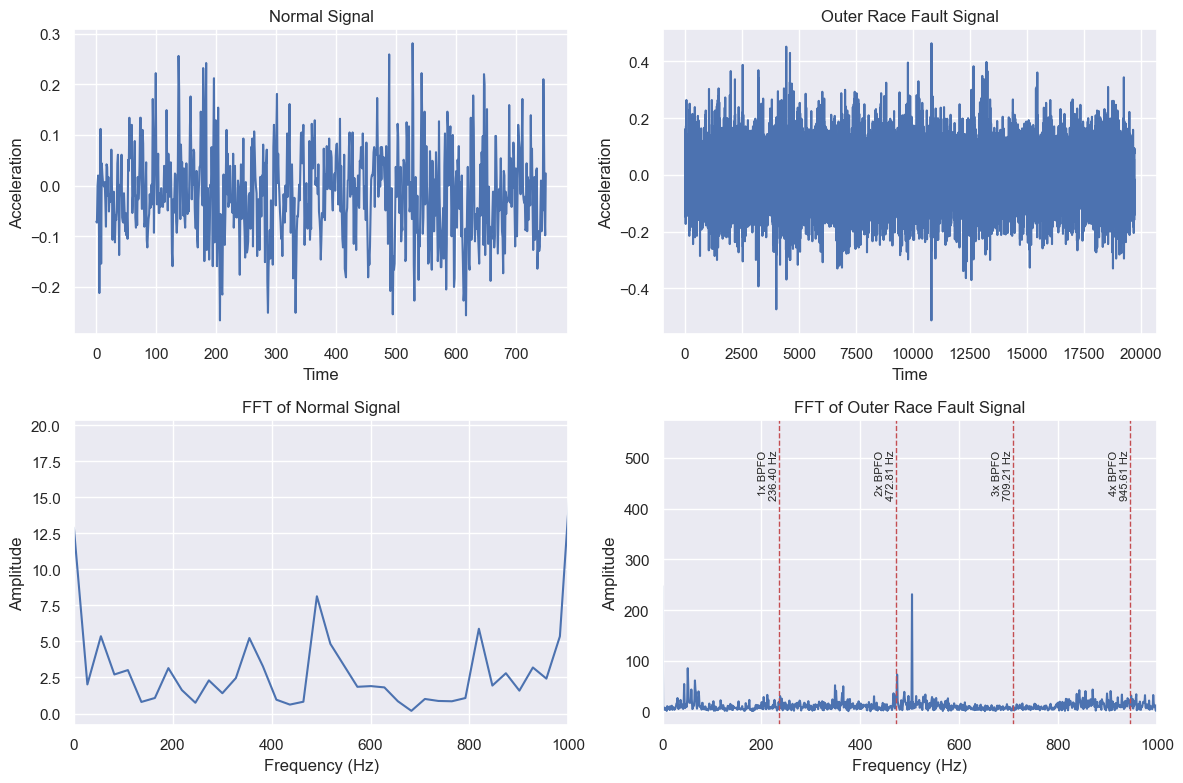

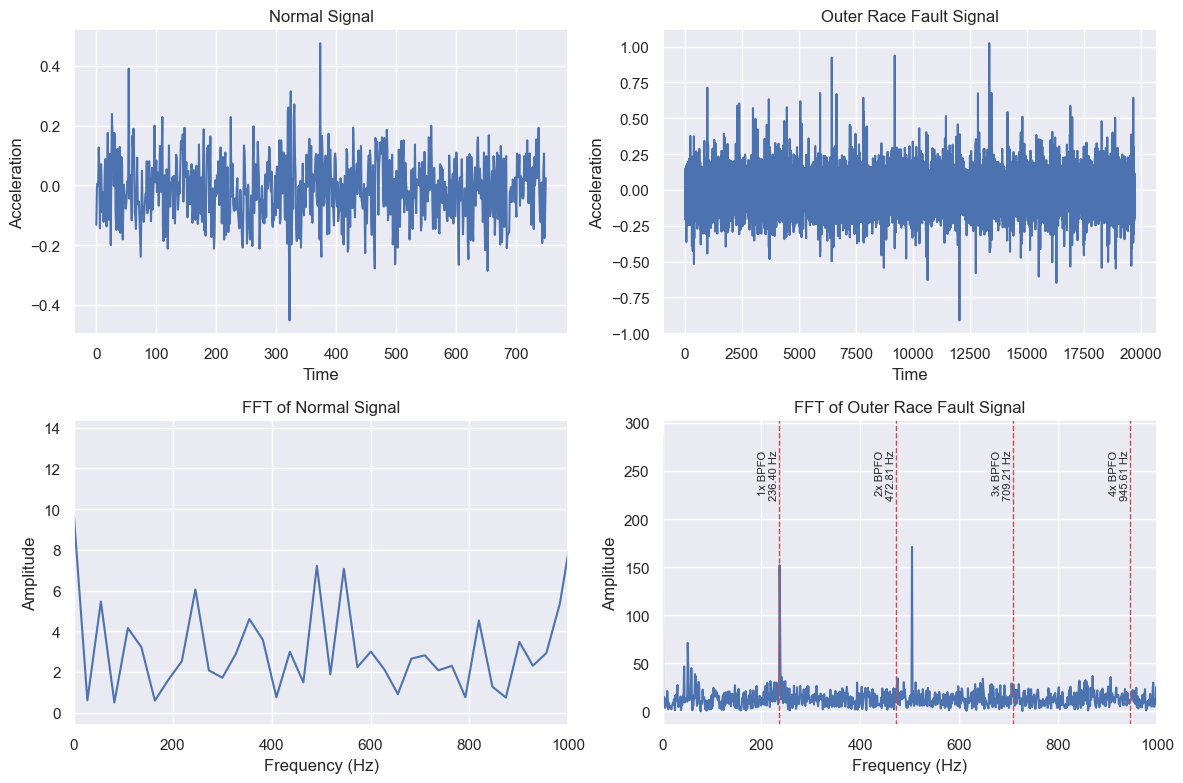

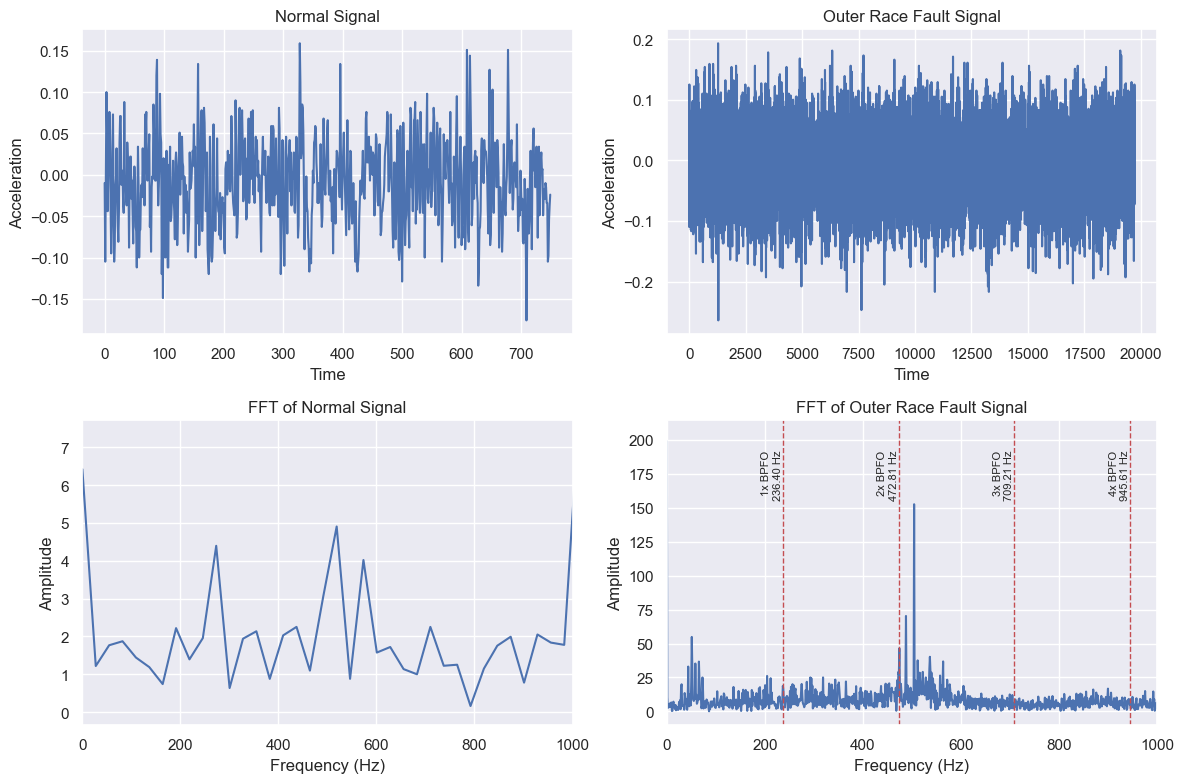

data dir path : C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/
length of files :  984
Reading file 1 of 984
Reading file 2 of 984
Reading file 3 of 984
Reading file 4 of 984
Reading file 5 of 984
Reading file 6 of 984
Reading file 7 of 984
Reading file 8 of 984
Reading file 9 of 984
Reading file 10 of 984
Reading file 11 of 984
Reading file 12 of 984
Reading file 13 of 984
Reading file 14 of 984
Reading file 15 of 984
Reading file 16 of 984
Reading file 17 of 984
Reading file 18 of 984
Reading file 19 of 984
Reading file 20 of 984
Reading file 21 of 984
Reading file 22 of 984
Reading file 23 of 984
Reading file 24 of 984
Reading file 25 of 984
Reading file 26 of 984
Reading file 27 of 984
Reading file 28 of 984
Reading file 29 of 984
Reading file 30 of 984
Reading file 31 of 984
Reading file 32 of 984
Reading file 33 of 984
Reading file 34 of 984
Reading file 35 of 984
Reading file 36 of 984
Reading file 37 of 984
Reading file 38 of 984
Reading file 39 of 984
Reading file 40 of

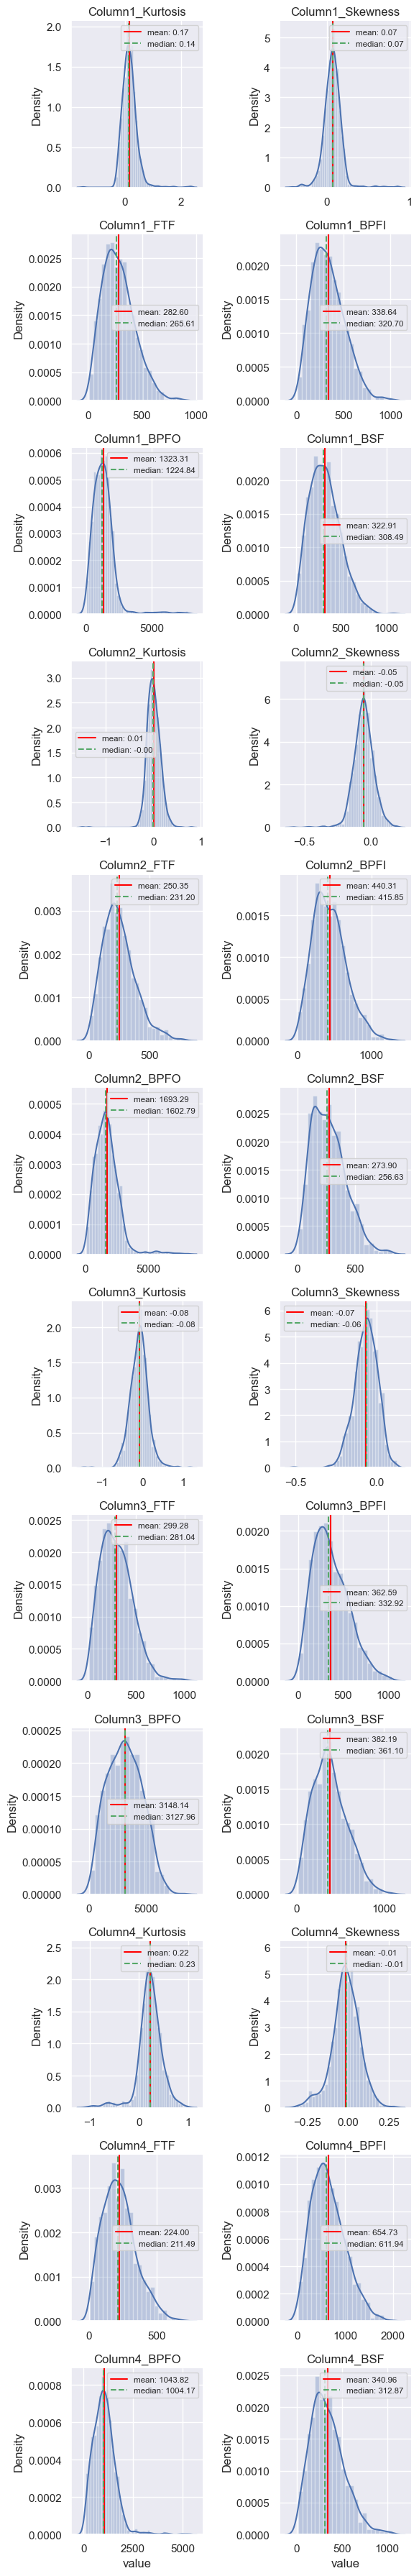

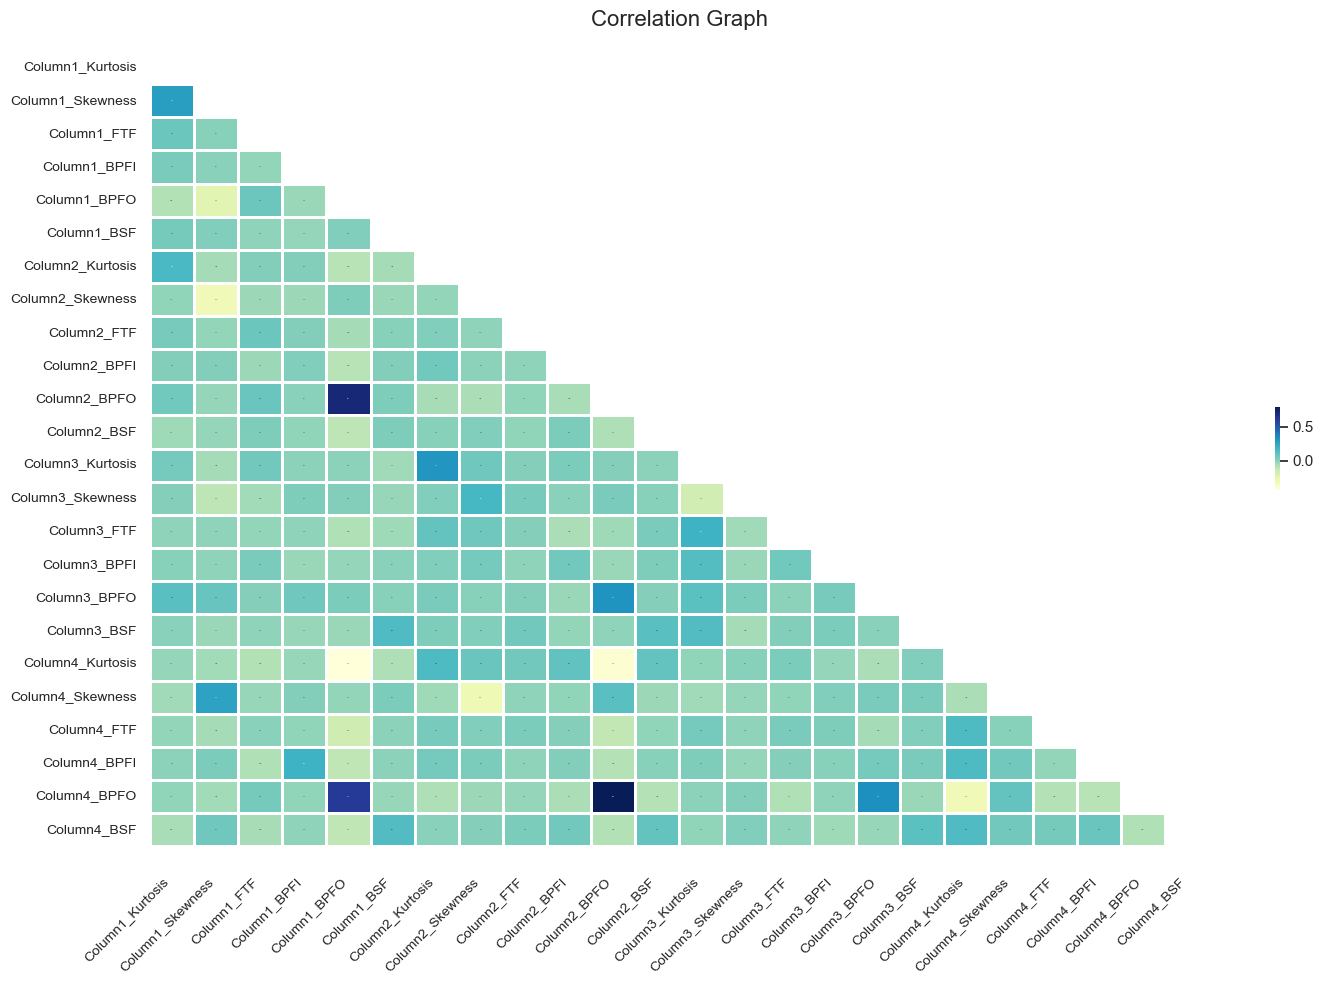

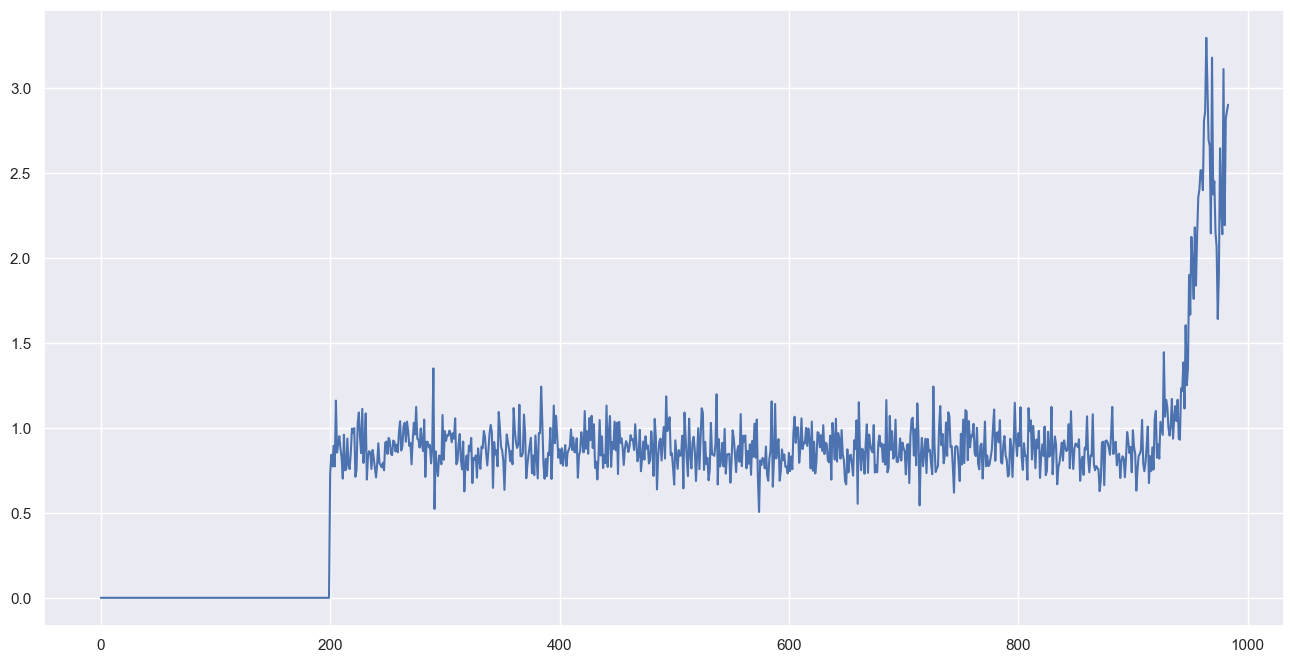

In [24]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.signal import butter, lfilter, savgol_filter, hilbert
#from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker
#from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.feature_engineering import FrequencyDomain
from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.data_analysis import SOM
from IntelliMaint.rul_models import GPRDegradationModel
from IntelliMaint.preprocessing import DataPreprocessing
from IntelliMaint.eda import ExploratoryAnalysis

import pickle as pkl
from imblearn.over_sampling import SMOTE

import sys
sys.path.insert(0, r'C:\Users\DELL\Desktop\Template\IntelliMaint')

from data_acquistion import DataAcquisition
from feature_engineering import TimeDomain, FrequencyDomain



class Bearing: #model of bearing done from bearing diag
    def __init__(self, files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols):
        self.files = files
        self.Bd = Bd
        self.Pd = Pd
        self.Nb = Nb
        self.a = a
        self.s = s
        self.sampRate = sampRate
        self.ratio = self.Bd / self.Pd * math.cos(self.a)
        self.ftf = self.s / 2 * (1 - self.ratio)
        self.bpfi = self.Nb / 2 * self.s * (1 + self.ratio)
        self.bpfo = self.Nb / 2 * self.s * (1 - self.ratio)
        self.bsf = self.Pd / self.Bd * self.s / 2 * (1 - self.ratio**2)
        self.bearFreq = [self.ftf, self.bpfi, self.bpfo, self.bsf]
        self.ber = ber
        self.n_cols = n_cols

    def analyze_raw_data(self, n_cols):
        rawData = pd.read_csv(self.files[0], sep='\t', header=None)
        
        for Col in range(self.n_cols):
            signal = rawData.iloc[:, Col].values

            # Split the signal into normal and outer_fault portions
            normal_signal = signal[:750]
            outer_fault_signal = signal[750:]

            # Plot the normal and outer race fault signals
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(normal_signal)
            plt.title('Normal Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            plt.subplot(2, 2, 2)
            plt.plot(outer_fault_signal)
            plt.title('Outer Race Fault Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            # Perform FFT on the normal and outer race fault signals
            normal_fft = np.abs(fft(normal_signal))
            outer_fault_fft = np.abs(fft(outer_fault_signal))
    
            freq_normal = np.fft.fftfreq(len(normal_signal), 1/self.sampRate)
            freq_outer_fault = np.fft.fftfreq(len(outer_fault_signal), 1/self.sampRate)
    
            # Plot the FFT of the normal signal
            plt.subplot(2, 2, 3)
            plt.plot(freq_normal[:len(freq_normal)//2], normal_fft[:len(normal_fft)//2])
            plt.title('FFT of Normal Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Plot the FFT of the outer race fault signal
            plt.subplot(2, 2, 4)
            plt.plot(freq_outer_fault[:len(freq_outer_fault)//2], outer_fault_fft[:len(outer_fault_fft)//2])
            plt.title('FFT of Outer Race Fault Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Add vertical lines for BPFO harmonics in the outer race fault FFT plot
            num_harmonics = 4  # Number of harmonics to plot
            for i in range(1, num_harmonics + 1):
                harmonic_freq = i * self.bpfo
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', linewidth=1, label=f'{i}x BPFO' if i == 1 else '')
                plt.text(harmonic_freq, plt.ylim()[1] * 0.9, f'{i}x BPFO\n{harmonic_freq:.2f} Hz', rotation=90, va='top', ha='right', fontsize=8)
    
            plt.tight_layout()
            plt.show()


    #def extract_time_domain_features(self, signal):
        #kurtosis_val = kurtosis(signal)
        #skewness_val = skew(signal)
        
        # Return kurtosis and skewness as the time-domain features
        #return [kurtosis_val, skewness_val]
        #features = TimeDomain.extract_features_streaming(pd.Series(signal))
        #return features

    #def extract_fft(self, signal):
        #return FrequencyDomain.extract_fft(signal)

    #def extract_domain_features(self, xf, amps):
        # Extract FTF, BPFI, BPFO, BSF as domain features
        #return FrequencyDomain.extract_domain_features(xf, amps)

    def extract_features(self, preprocessed_signal):
    # Create an instance of TimeDomain
        td = TimeDomain()

    # Extract only kurtosis and skewness for the given signal
    # Assuming preprocessed_signal is in a format suitable for processing (NumPy array or DataFrame)
        kurtosis_val = td.get_kurtosis(preprocessed_signal)
        skewness_val = td.get_skewness(preprocessed_signal)

    # Combine kurtosis and skewness into a tuple for time-domain features
        time_features = (kurtosis_val, skewness_val)

    # Extract FFT domain features using FrequencyDomain
        fd = FrequencyDomain(self.sampRate, self.ftf, self.bpfi, self.bpfo, self.bsf, preprocessed_signal)
        domain_features = fd.extract_features(preprocessed_signal)

    # Convert domain_features to a tuple if not already
        domain_features = tuple(domain_features)

    # Return the combined features (time domain + FFT domain)
        return time_features + domain_features



# Get data from the directory
data_dir_path = r'C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/'
data_acquisition = DataAcquisition()


# Get list of files
files = DataAcquisition.get_file_list(data_dir_path)
print(f"Total files found: {len(files)}")

# Get list of files
# Call the class method directly on the class, not the object
#files = DataAcquisition.get_file_list(data_dir_path)

#files = data_acquistion.get_file_list()
#print(len(files))
#print("---")


# Get all CSV files from the folder
#files = sorted(glob.glob(folder_path + '200*'))  # Sort files to ensure chronological order

#folder_path = r'C:\Users\DELL\Desktop\Navtat\inteliMaint-main\inteliMaint-main\examples\data\2nd_test\2nd_test/'
#print(folder_path)
#files = glob.glob(folder_path + '200*')[:]
#print(len(files))

############################################
Bd = 0.331  # ball diameter, in inches
Pd = 2.815  # pitch diameter, in inches
Nb = 16  # number of rolling elements
a = 15.17 * math.pi / 180  # contact angle, in radians
s = 2000 / 60  # rotational frequency, in Hz
ber = 0 #Can add ber to get raw_data plot for all ber
n_cols = 4


ratio = Bd / Pd * math.cos(a)
ftf = s / 2 * (1 - ratio)
bpfi = Nb / 2 * s * (1 + ratio)
bpfo = Nb / 2 * s * (1 - ratio)
bsf = Pd / Bd * s / 2 * (1 - ratio**2)
bearFreq = [ftf, bpfi, bpfo, bsf]
sampRate = 20480  # Sampling rate, in Hz
##############################################

bearing = Bearing(files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols) #Can add ber to get raw_data plot for all ber

###################################
# Analyze raw vibration data
ber = 0
n_cols = 4
bearing.analyze_raw_data(ber)
##################################

# Initialize Preprocessing
preprocessing = DataPreprocessing()
df = data_acquisition.get_data_from_dir(data_dir_path)

# Lists to store all features and timestamps
all_features = []
all_timestamps = []

# Process each file
for file_path in files:
    df = DataAcquisition.get_data_from_file(file_path)
    file_features = []
    for Col in range(n_cols):  # Iterate through each column (sensor)
    #rawData = pd.read_csv(df.files[0], sep='\t', header=None)
        signal = pd.to_numeric(df.iloc[:, Col], errors= 'coerce').dropna().values
        signal = np.array(signal, dtype=float)  # Convert to numpy array
        preprocessed_signal = preprocessing.preprocess(signal, operations=['filter', 'smooth', 'normalize'])

    
    # Plot the preprocessed signal (after preprocessing)
    #plt.figure(figsize=(10, 4))
    #plt.plot(preprocessed_signal, label=f'Preprocessed Signal - Sensor {Col+1}', color='orange')
    #plt.title(f'Preprocessed Signal - Sensor {Col+1}')
    #plt.xlabel('Sample Index')
    #plt.ylabel('Amplitude')
    #plt.legend()
    #plt.show()

        features = bearing.extract_features(preprocessed_signal)
        file_features.extend(features)

    # Append features and timestamps
    all_features.append(file_features)


time_domain_columns = ['Kurtosis', 'Skewness'] #to correct ValueError: 6 columns passed, passed data had 18 columns
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']
all_columns = time_domain_columns + domain_columns
num_features_per_column = len(time_domain_columns + domain_columns) #To verify not to get error in Number of column PASSED
sensor_columns = [f'Column{Col+1}_{feat}' for Col in range(n_cols) for feat in all_columns]
print(sensor_columns)  # Verify the number of columns
feature_df = pd.DataFrame(all_features, columns=sensor_columns)    

print("Feature DataFrame:\n", feature_df.head())

eda_results = ExploratoryAnalysis.perform_eda(feature_df)

# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)



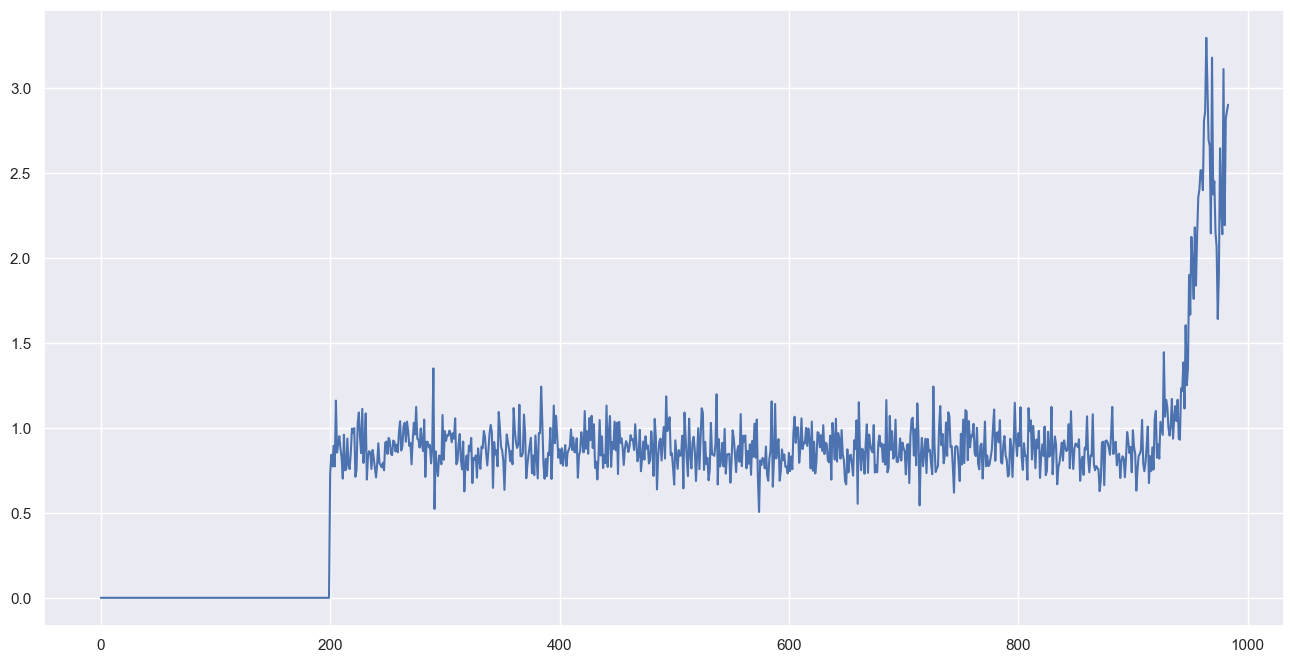

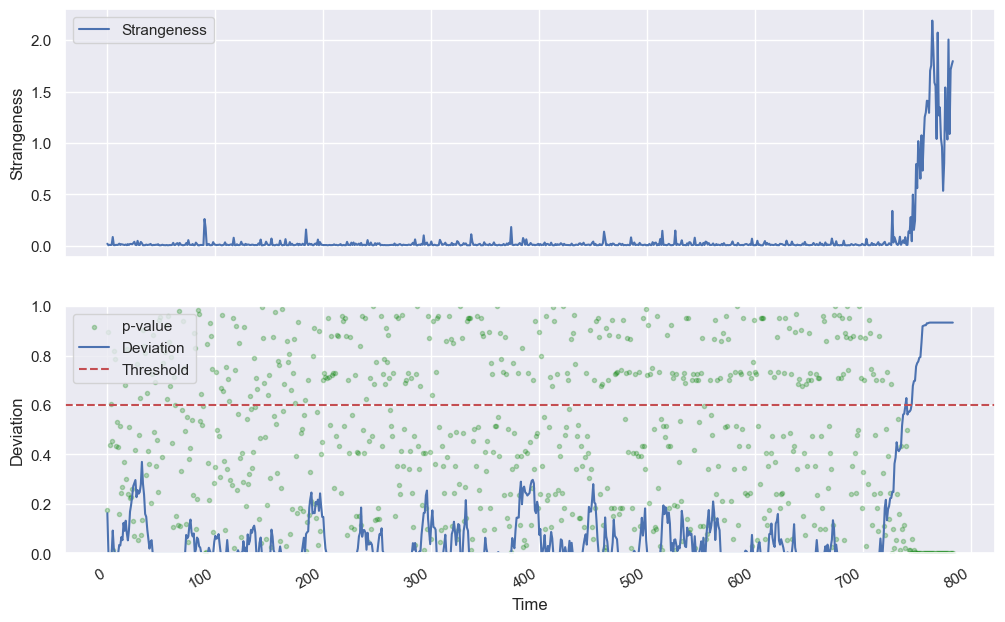

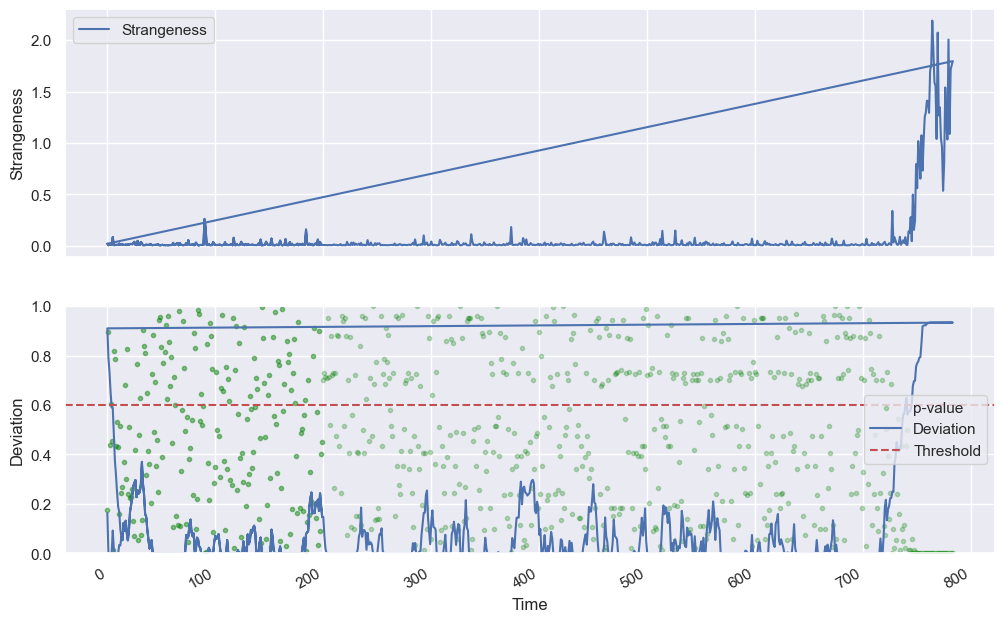

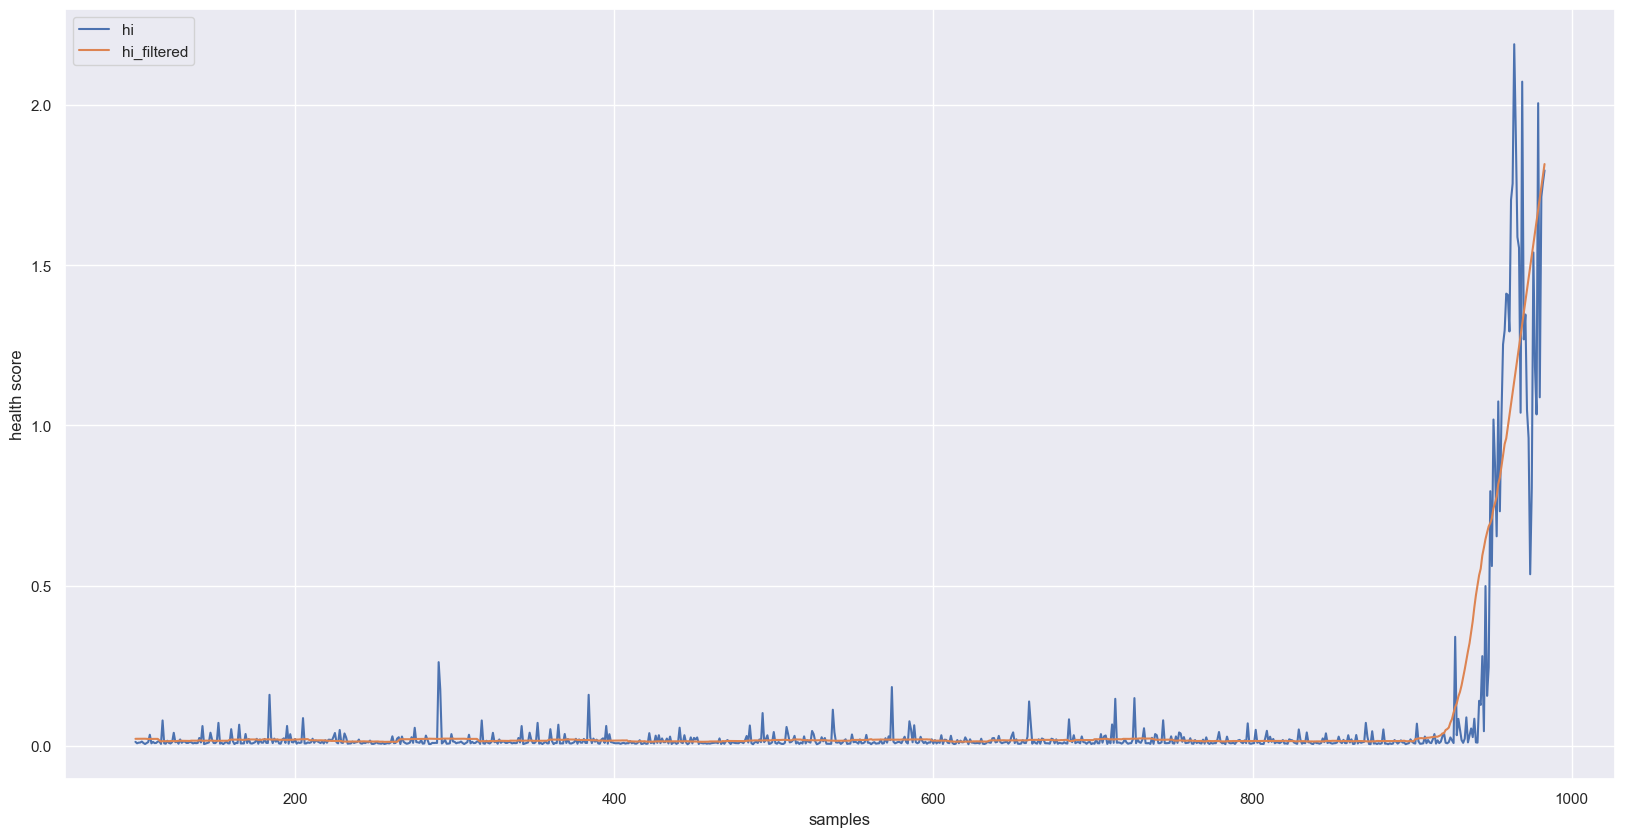

In [42]:
# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)




# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som+normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

score_train = []
score_test = []

for i in range(hi_train.shape[0]):
    score_train.append(health_score_train[i])

for i in range(hi_test.shape[0]):
    score_test.append(health_score_test[i])

h_score = score_train + score_test
h_score = np.array(h_score)

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()


----
Found 984 files in the directory.
Total files found: 984


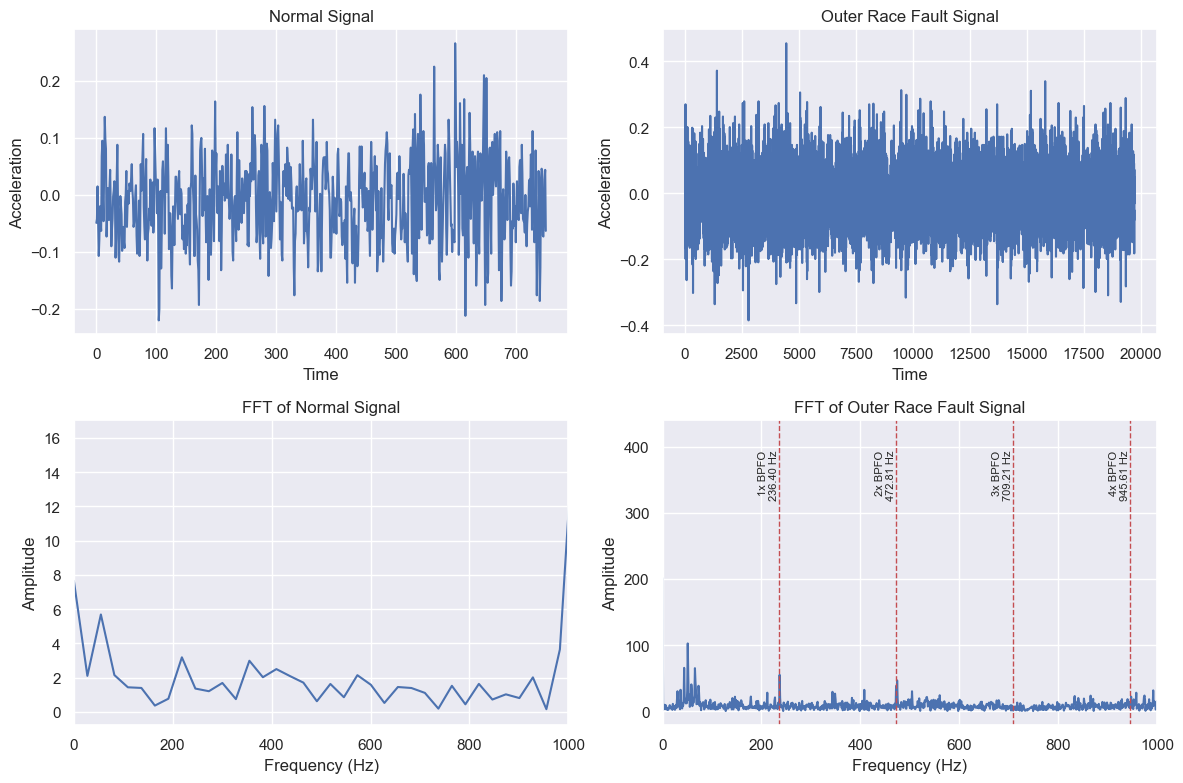

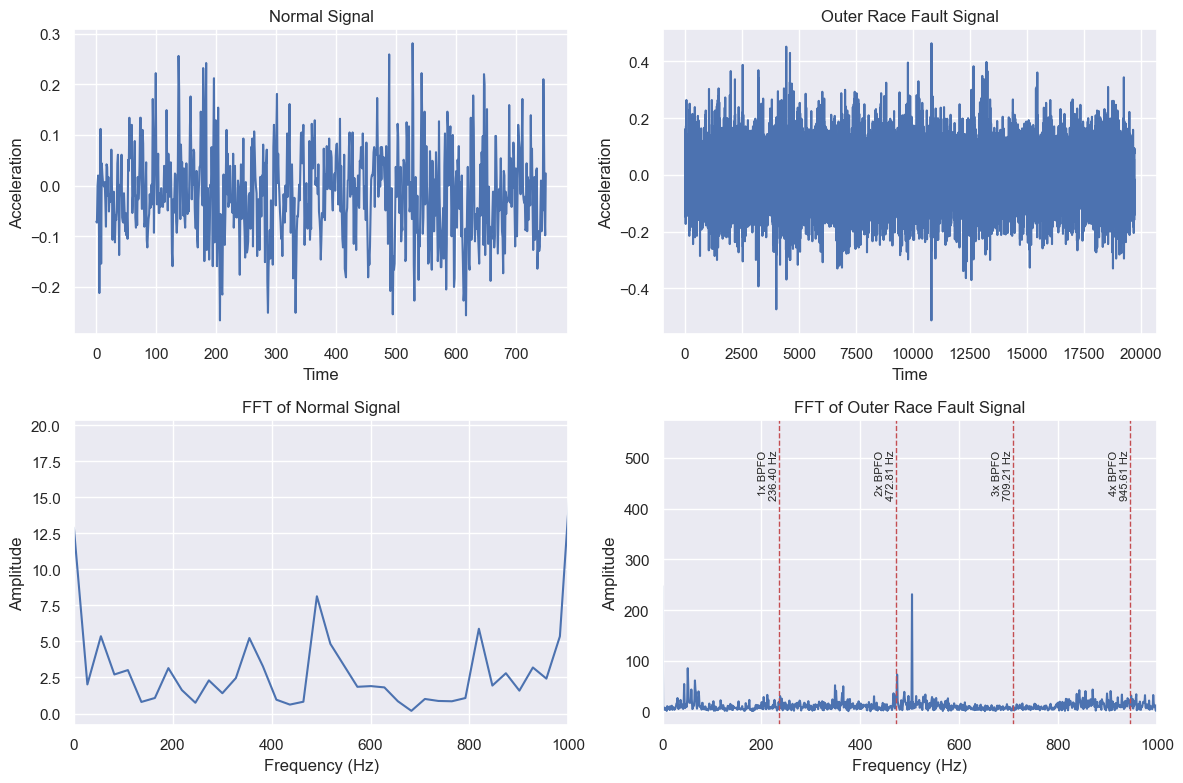

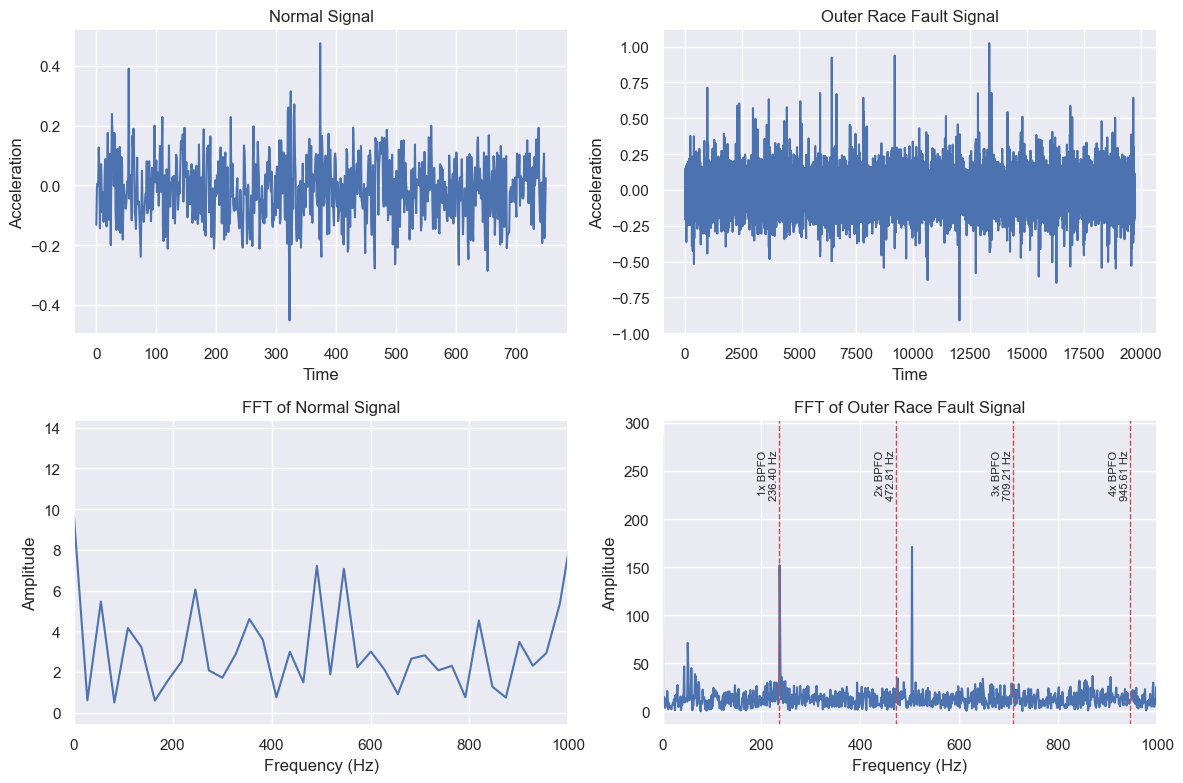

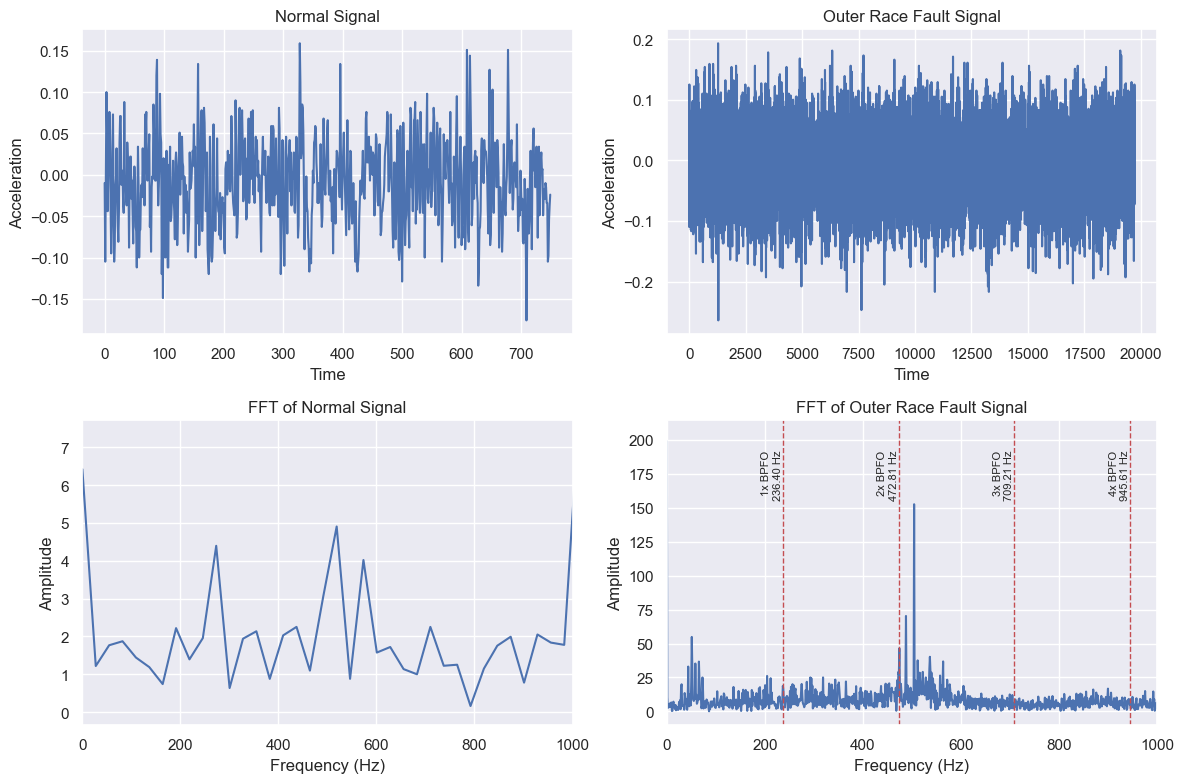

data dir path : C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/
length of files :  984
Reading file 1 of 984
Reading file 2 of 984
Reading file 3 of 984
Reading file 4 of 984
Reading file 5 of 984
Reading file 6 of 984
Reading file 7 of 984
Reading file 8 of 984
Reading file 9 of 984
Reading file 10 of 984
Reading file 11 of 984
Reading file 12 of 984
Reading file 13 of 984
Reading file 14 of 984
Reading file 15 of 984
Reading file 16 of 984
Reading file 17 of 984
Reading file 18 of 984
Reading file 19 of 984
Reading file 20 of 984
Reading file 21 of 984
Reading file 22 of 984
Reading file 23 of 984
Reading file 24 of 984
Reading file 25 of 984
Reading file 26 of 984
Reading file 27 of 984
Reading file 28 of 984
Reading file 29 of 984
Reading file 30 of 984
Reading file 31 of 984
Reading file 32 of 984
Reading file 33 of 984
Reading file 34 of 984
Reading file 35 of 984
Reading file 36 of 984
Reading file 37 of 984
Reading file 38 of 984
Reading file 39 of 984
Reading file 40 of

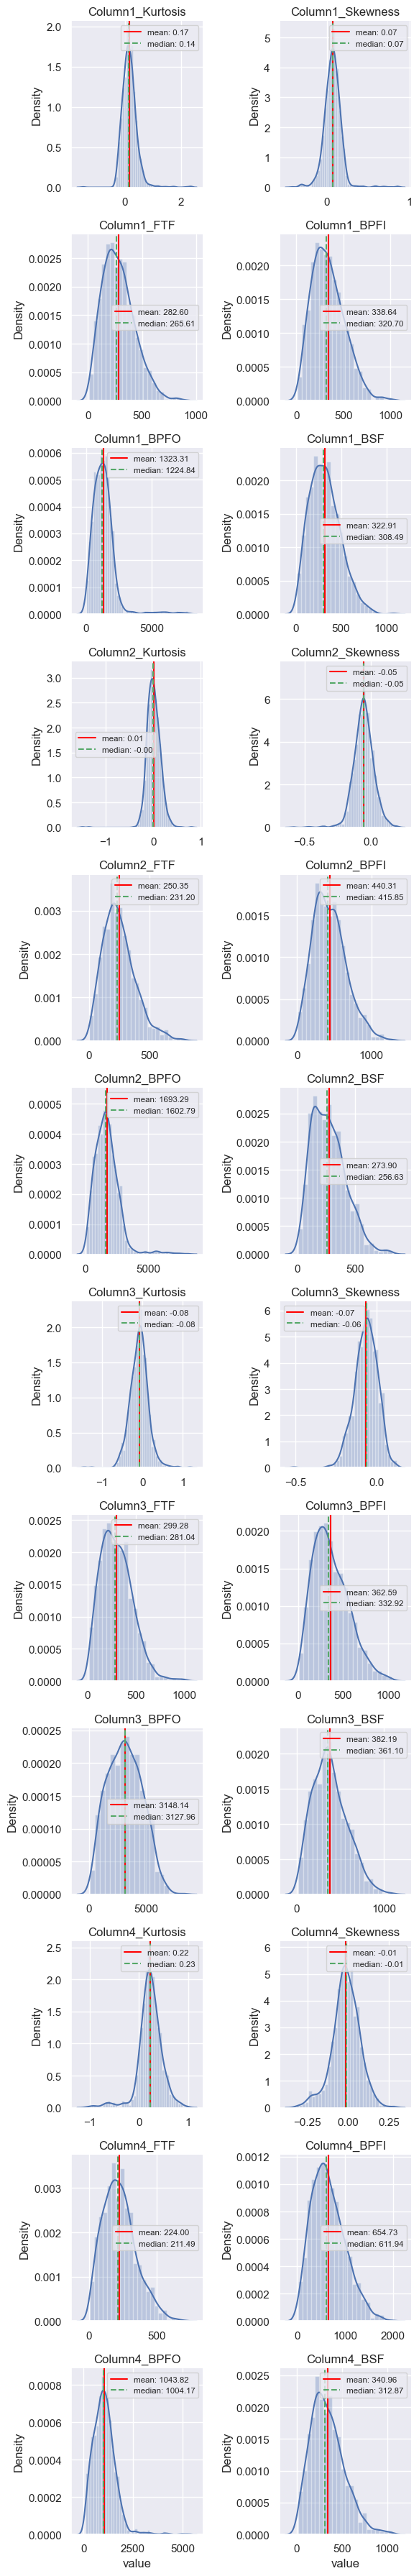

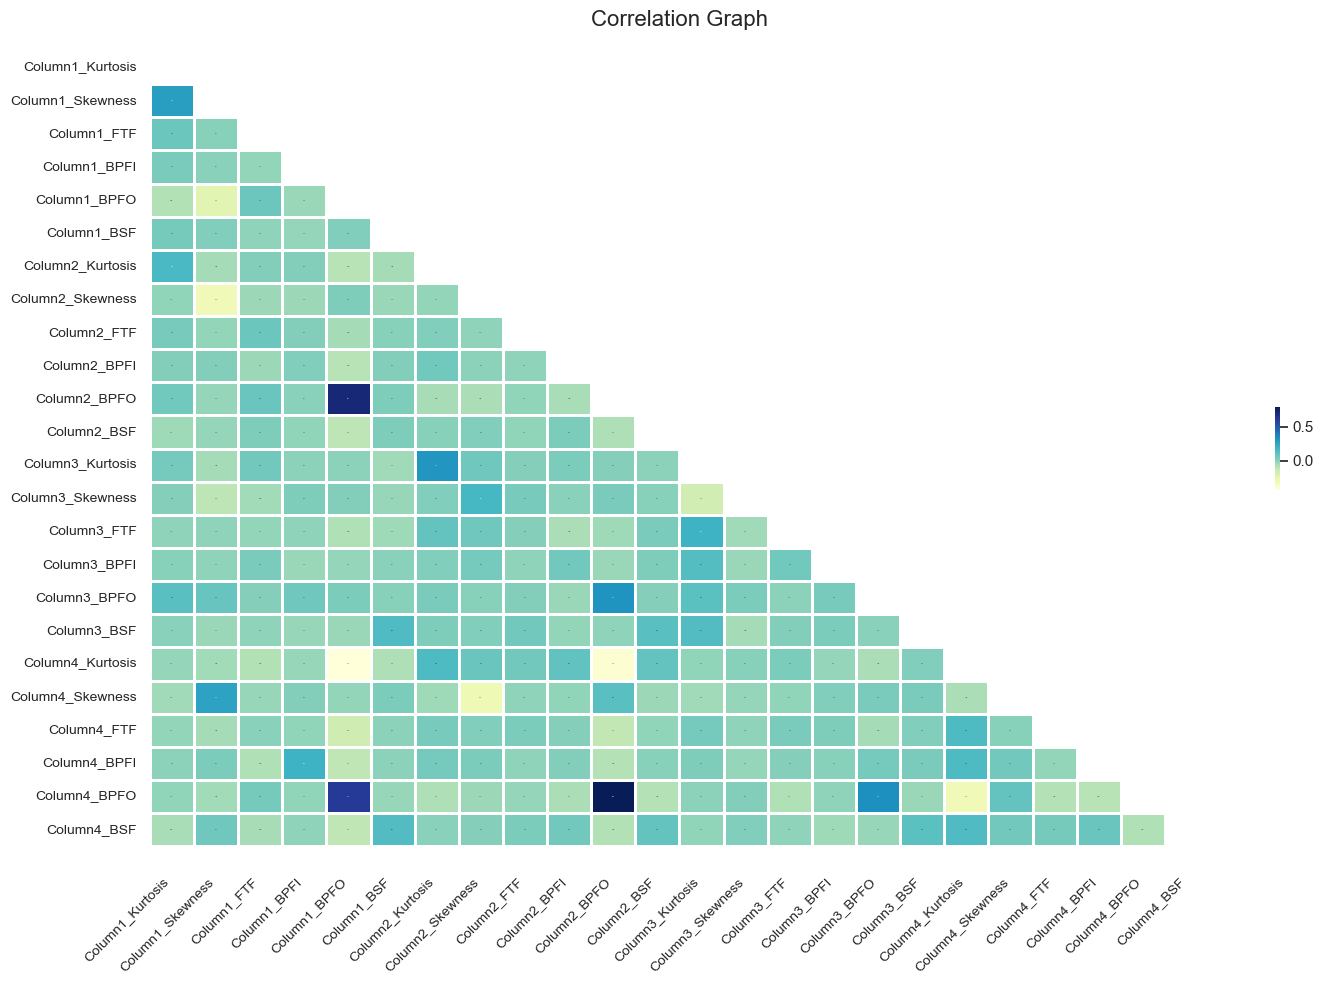

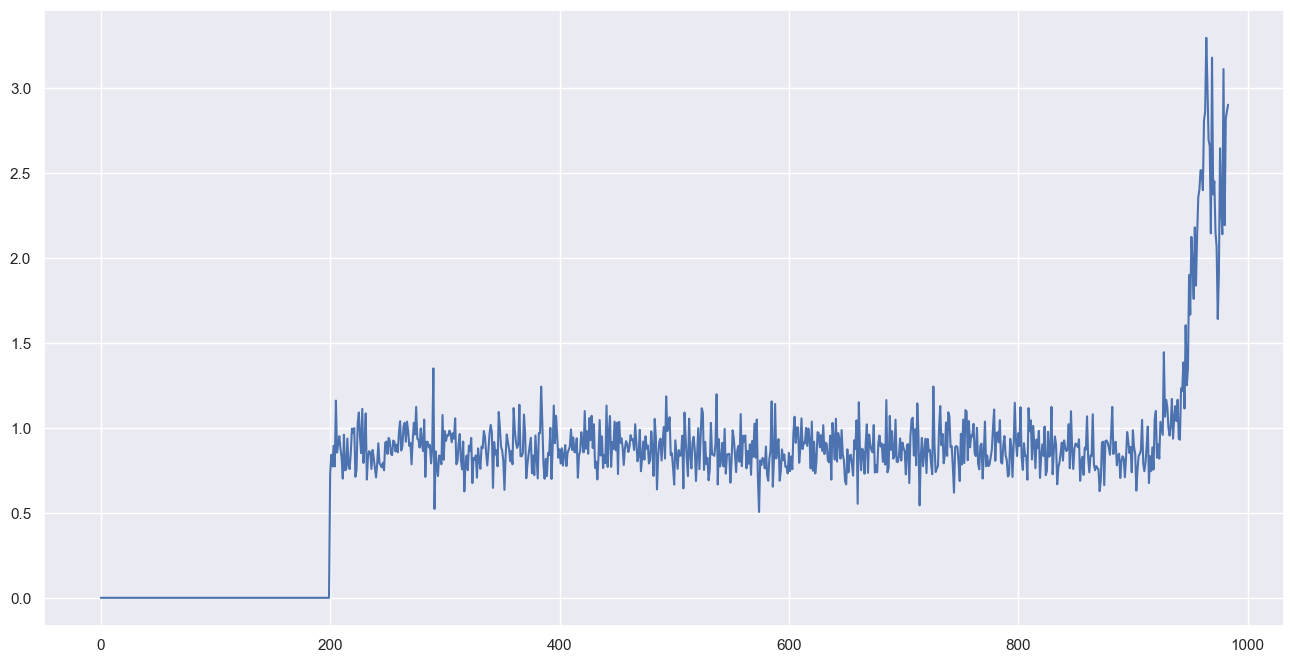

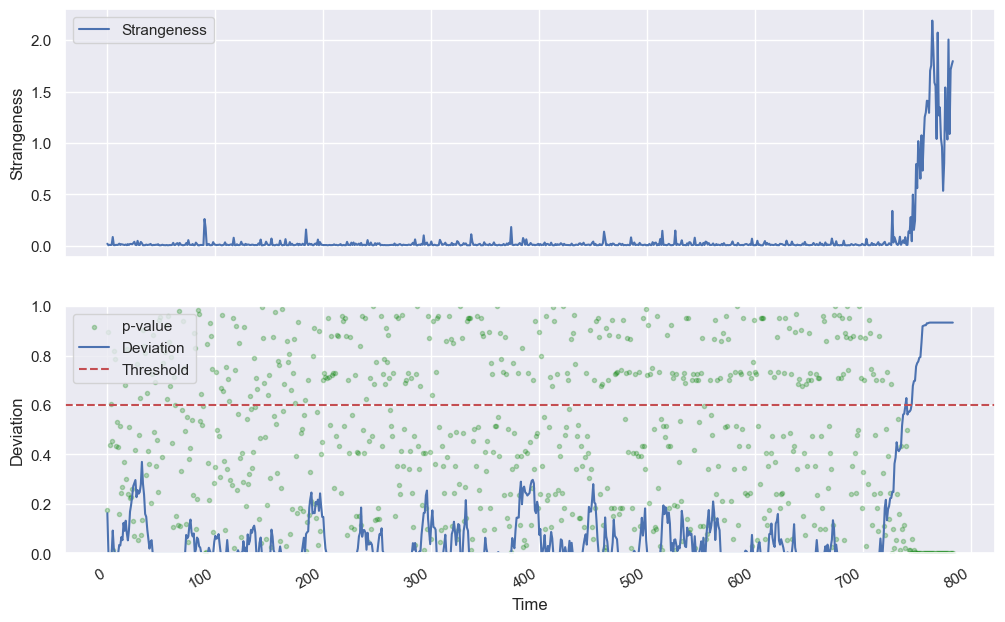

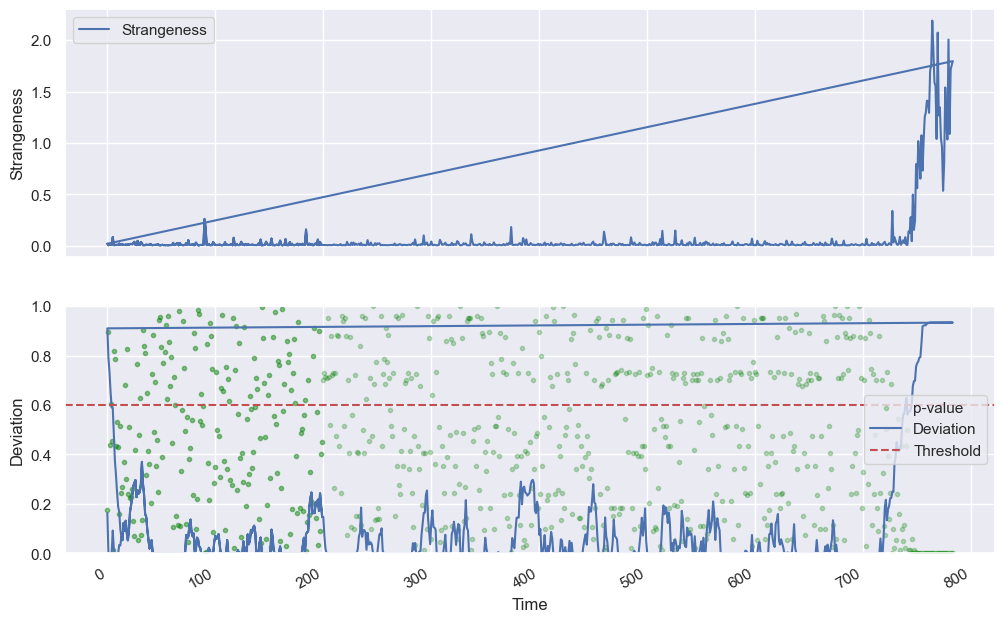

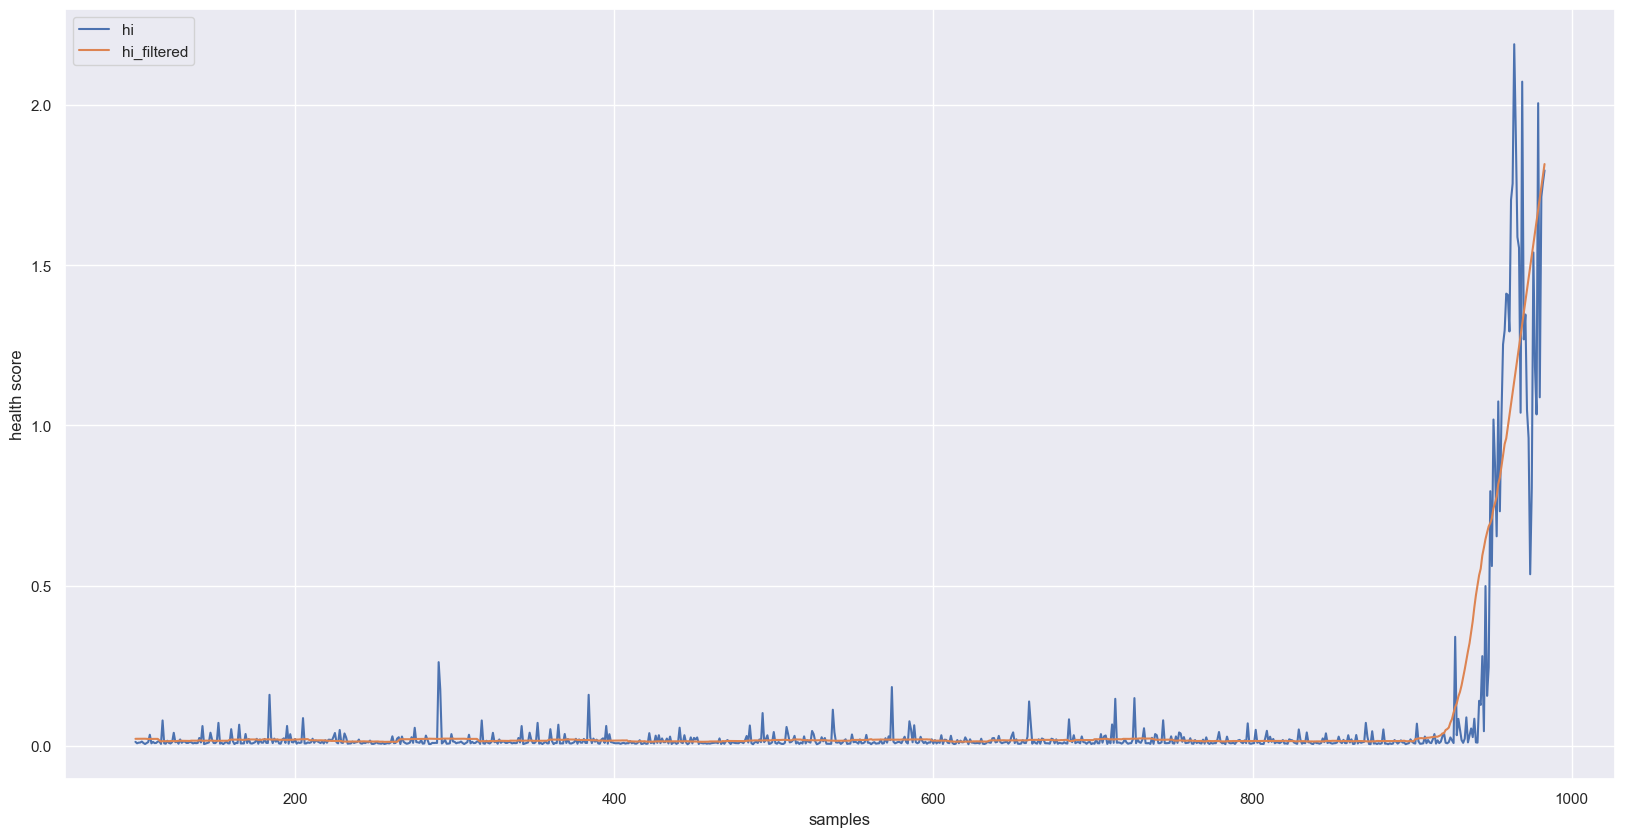

[0.00508647 0.02746694 0.00101729 0.00712106 0.01322482 0.00101729
 0.00915565 0.00508647 0.01525941 0.00101729 0.00915565 0.02543235
 0.00508647 0.01119023 0.017294   0.00305188 0.00508647 0.01322482
 0.00508647 0.02543235 0.00305188 0.00915565 0.02543235 0.00915565]


In [5]:

import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.signal import butter, lfilter, savgol_filter, hilbert
#from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker
#from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.feature_engineering import FrequencyDomain
from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.data_analysis import SOM
from IntelliMaint.rul_models import GPRDegradationModel
from IntelliMaint.preprocessing import DataPreprocessing
from IntelliMaint.eda import ExploratoryAnalysis
from IntelliMaint.health_assessment import HealthIndicator
#from IntelliMaint.Utils import Utils  # Import the Utils class

import pickle as pkl
from imblearn.over_sampling import SMOTE

import sys
sys.path.insert(0, r'C:\Users\DELL\Desktop\Template\IntelliMaint')

from data_acquistion import DataAcquisition
from feature_engineering import TimeDomain, FrequencyDomain



class Bearing: #model of bearing done from bearing diag
    def __init__(self, files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols):
        self.files = files
        self.Bd = Bd
        self.Pd = Pd
        self.Nb = Nb
        self.a = a
        self.s = s
        self.sampRate = sampRate
        self.ratio = self.Bd / self.Pd * math.cos(self.a)
        self.ftf = self.s / 2 * (1 - self.ratio)
        self.bpfi = self.Nb / 2 * self.s * (1 + self.ratio)
        self.bpfo = self.Nb / 2 * self.s * (1 - self.ratio)
        self.bsf = self.Pd / self.Bd * self.s / 2 * (1 - self.ratio**2)
        self.bearFreq = [self.ftf, self.bpfi, self.bpfo, self.bsf]
        self.ber = ber
        self.n_cols = n_cols

    def analyze_raw_data(self, n_cols):
        rawData = pd.read_csv(self.files[0], sep='\t', header=None)
        
        for Col in range(self.n_cols):
            signal = rawData.iloc[:, Col].values

            # Split the signal into normal and outer_fault portions
            normal_signal = signal[:750]
            outer_fault_signal = signal[750:]

            # Plot the normal and outer race fault signals
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(normal_signal)
            plt.title('Normal Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            plt.subplot(2, 2, 2)
            plt.plot(outer_fault_signal)
            plt.title('Outer Race Fault Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            # Perform FFT on the normal and outer race fault signals
            normal_fft = np.abs(fft(normal_signal))
            outer_fault_fft = np.abs(fft(outer_fault_signal))
    
            freq_normal = np.fft.fftfreq(len(normal_signal), 1/self.sampRate)
            freq_outer_fault = np.fft.fftfreq(len(outer_fault_signal), 1/self.sampRate)
    
            # Plot the FFT of the normal signal
            plt.subplot(2, 2, 3)
            plt.plot(freq_normal[:len(freq_normal)//2], normal_fft[:len(normal_fft)//2])
            plt.title('FFT of Normal Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Plot the FFT of the outer race fault signal
            plt.subplot(2, 2, 4)
            plt.plot(freq_outer_fault[:len(freq_outer_fault)//2], outer_fault_fft[:len(outer_fault_fft)//2])
            plt.title('FFT of Outer Race Fault Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Add vertical lines for BPFO harmonics in the outer race fault FFT plot
            num_harmonics = 4  # Number of harmonics to plot
            for i in range(1, num_harmonics + 1):
                harmonic_freq = i * self.bpfo
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', linewidth=1, label=f'{i}x BPFO' if i == 1 else '')
                plt.text(harmonic_freq, plt.ylim()[1] * 0.9, f'{i}x BPFO\n{harmonic_freq:.2f} Hz', rotation=90, va='top', ha='right', fontsize=8)
    
            plt.tight_layout()
            plt.show()


    #def extract_time_domain_features(self, signal):
        #kurtosis_val = kurtosis(signal)
        #skewness_val = skew(signal)
        
        # Return kurtosis and skewness as the time-domain features
        #return [kurtosis_val, skewness_val]
        #features = TimeDomain.extract_features_streaming(pd.Series(signal))
        #return features

    #def extract_fft(self, signal):
        #return FrequencyDomain.extract_fft(signal)

    #def extract_domain_features(self, xf, amps):
        # Extract FTF, BPFI, BPFO, BSF as domain features
        #return FrequencyDomain.extract_domain_features(xf, amps)

    def extract_features(self, preprocessed_signal):
    # Create an instance of TimeDomain
        td = TimeDomain()

    # Extract only kurtosis and skewness for the given signal
    # Assuming preprocessed_signal is in a format suitable for processing (NumPy array or DataFrame)
        kurtosis_val = td.get_kurtosis(preprocessed_signal)
        skewness_val = td.get_skewness(preprocessed_signal)

    # Combine kurtosis and skewness into a tuple for time-domain features
        time_features = (kurtosis_val, skewness_val)

    # Extract FFT domain features using FrequencyDomain
        fd = FrequencyDomain(self.sampRate, self.ftf, self.bpfi, self.bpfo, self.bsf, preprocessed_signal)
        domain_features = fd.extract_features(preprocessed_signal)

    # Convert domain_features to a tuple if not already
        domain_features = tuple(domain_features)

    # Return the combined features (time domain + FFT domain)
        return time_features + domain_features



# Get data from the directory
data_dir_path = r'C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/'
data_acquisition = DataAcquisition()


# Get list of files
files = DataAcquisition.get_file_list(data_dir_path)
print(f"Total files found: {len(files)}")

# Get list of files
# Call the class method directly on the class, not the object
#files = DataAcquisition.get_file_list(data_dir_path)

#files = data_acquistion.get_file_list()
#print(len(files))
#print("---")


# Get all CSV files from the folder
#files = sorted(glob.glob(folder_path + '200*'))  # Sort files to ensure chronological order

#folder_path = r'C:\Users\DELL\Desktop\Navtat\inteliMaint-main\inteliMaint-main\examples\data\2nd_test\2nd_test/'
#print(folder_path)
#files = glob.glob(folder_path + '200*')[:]
#print(len(files))

############################################
Bd = 0.331  # ball diameter, in inches
Pd = 2.815  # pitch diameter, in inches
Nb = 16  # number of rolling elements
a = 15.17 * math.pi / 180  # contact angle, in radians
s = 2000 / 60  # rotational frequency, in Hz
ber = 0 #Can add ber to get raw_data plot for all ber
n_cols = 4


ratio = Bd / Pd * math.cos(a)
ftf = s / 2 * (1 - ratio)
bpfi = Nb / 2 * s * (1 + ratio)
bpfo = Nb / 2 * s * (1 - ratio)
bsf = Pd / Bd * s / 2 * (1 - ratio**2)
bearFreq = [ftf, bpfi, bpfo, bsf]
sampRate = 20480  # Sampling rate, in Hz
##############################################

bearing = Bearing(files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols) #Can add ber to get raw_data plot for all ber

###################################
# Analyze raw vibration data
ber = 0
n_cols = 4
bearing.analyze_raw_data(ber)
##################################

# Initialize Preprocessing
preprocessing = DataPreprocessing()
df = data_acquisition.get_data_from_dir(data_dir_path)

# Lists to store all features and timestamps
all_features = []
all_timestamps = []

# Process each file
for file_path in files:
    df = DataAcquisition.get_data_from_file(file_path)
    file_features = []
    for Col in range(n_cols):  # Iterate through each column (sensor)
    #rawData = pd.read_csv(df.files[0], sep='\t', header=None)
        signal = pd.to_numeric(df.iloc[:, Col], errors= 'coerce').dropna().values
        signal = np.array(signal, dtype=float)  # Convert to numpy array
        preprocessed_signal = preprocessing.preprocess(signal, operations=['filter', 'smooth', 'normalize'])

    
    # Plot the preprocessed signal (after preprocessing)
    #plt.figure(figsize=(10, 4))
    #plt.plot(preprocessed_signal, label=f'Preprocessed Signal - Sensor {Col+1}', color='orange')
    #plt.title(f'Preprocessed Signal - Sensor {Col+1}')
    #plt.xlabel('Sample Index')
    #plt.ylabel('Amplitude')
    #plt.legend()
    #plt.show()

        features = bearing.extract_features(preprocessed_signal)
        file_features.extend(features)

    # Append features and timestamps
    all_features.append(file_features)


time_domain_columns = ['Kurtosis', 'Skewness'] #to correct ValueError: 6 columns passed, passed data had 18 columns
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']
all_columns = time_domain_columns + domain_columns
num_features_per_column = len(time_domain_columns + domain_columns) #To verify not to get error in Number of column PASSED
sensor_columns = [f'Column{Col+1}_{feat}' for Col in range(n_cols) for feat in all_columns]
print(sensor_columns)  # Verify the number of columns
feature_df = pd.DataFrame(all_features, columns=sensor_columns)    

print("Feature DataFrame:\n", feature_df.head())

eda_results = ExploratoryAnalysis.perform_eda(feature_df)

# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)




# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som+normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

score_train = []
score_test = []

for i in range(hi_train.shape[0]):
    score_train.append(health_score_train[i])

for i in range(hi_test.shape[0]):
    score_test.append(health_score_test[i])

h_score = score_train + score_test
h_score = np.array(h_score)

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()




# Assuming you already have the data
# For example, if feature_df is the dataframe containing the features:
data = feature_df.values

# Initialize the HealthIndicator and Utils classes
health_indicator = HealthIndicator()
#utils = Utils()  # Instantiate the Utils class


health_scores = health_indicator.computeHIScore(data, method='mon')  # 'mon' can be replaced with the desired method

# Print or use the health_scores for further analysis
print(health_scores)



----
Found 984 files in the directory.
Total files found: 984


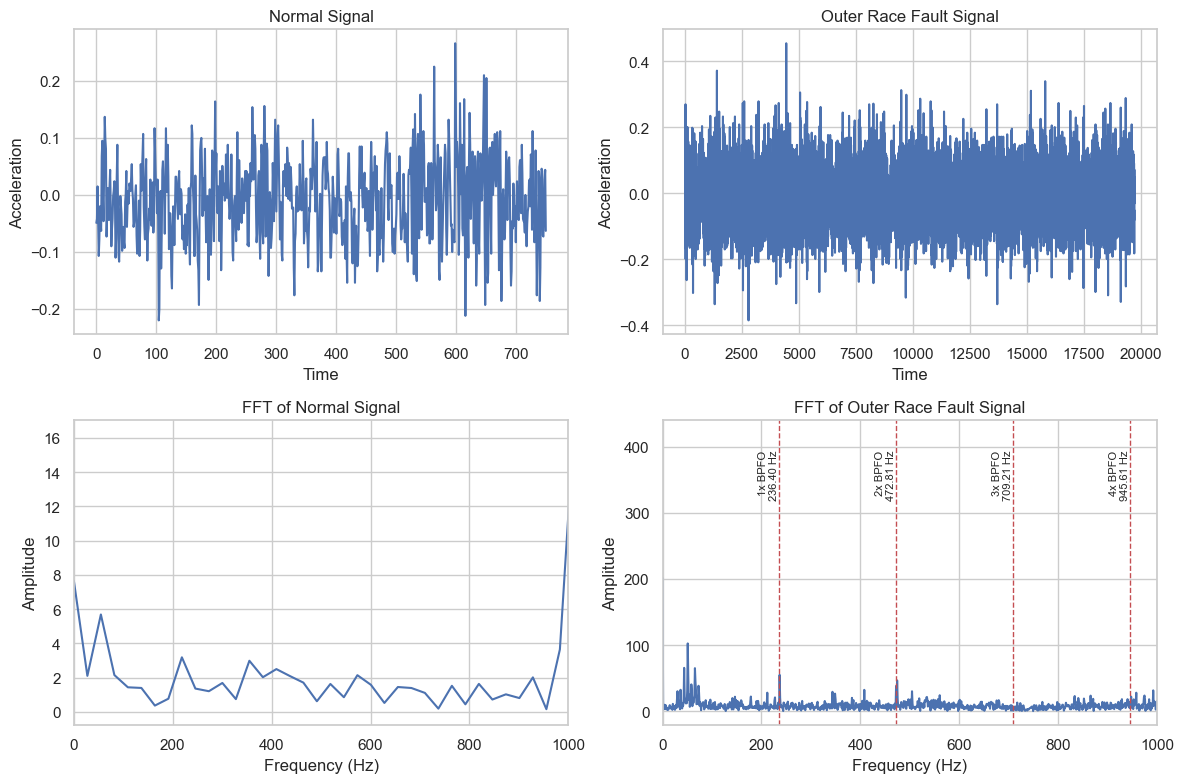

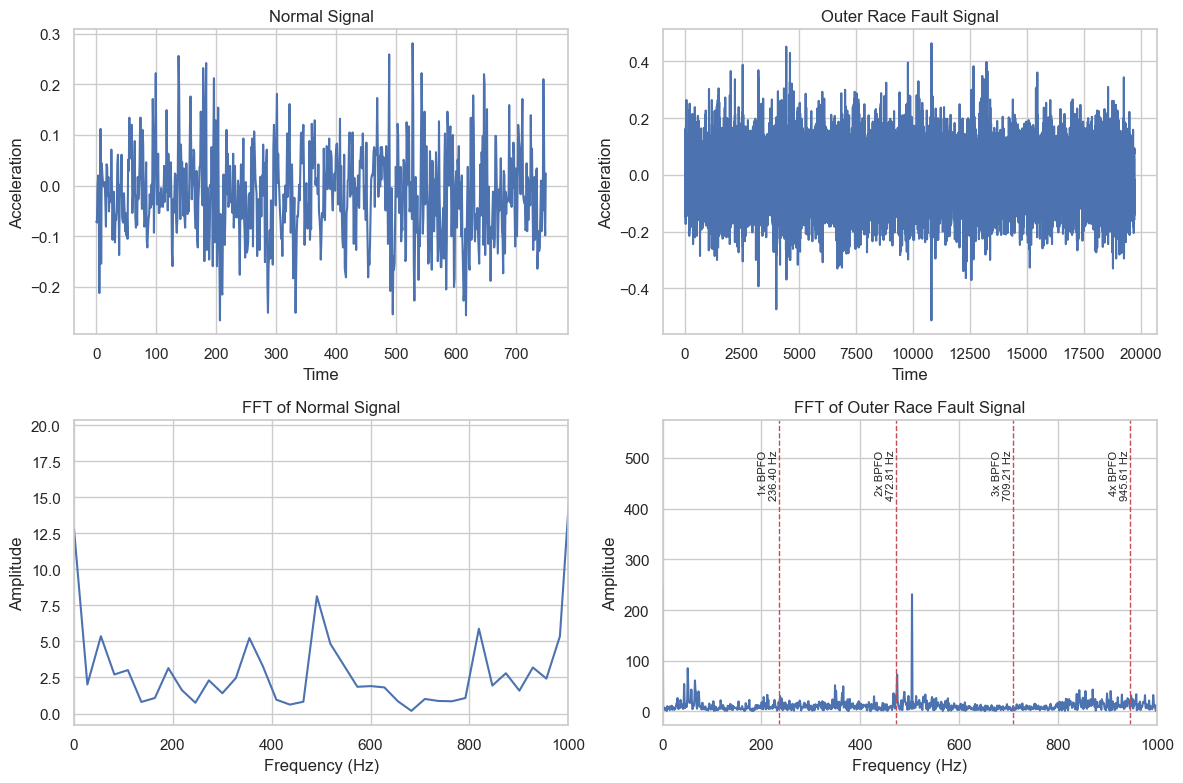

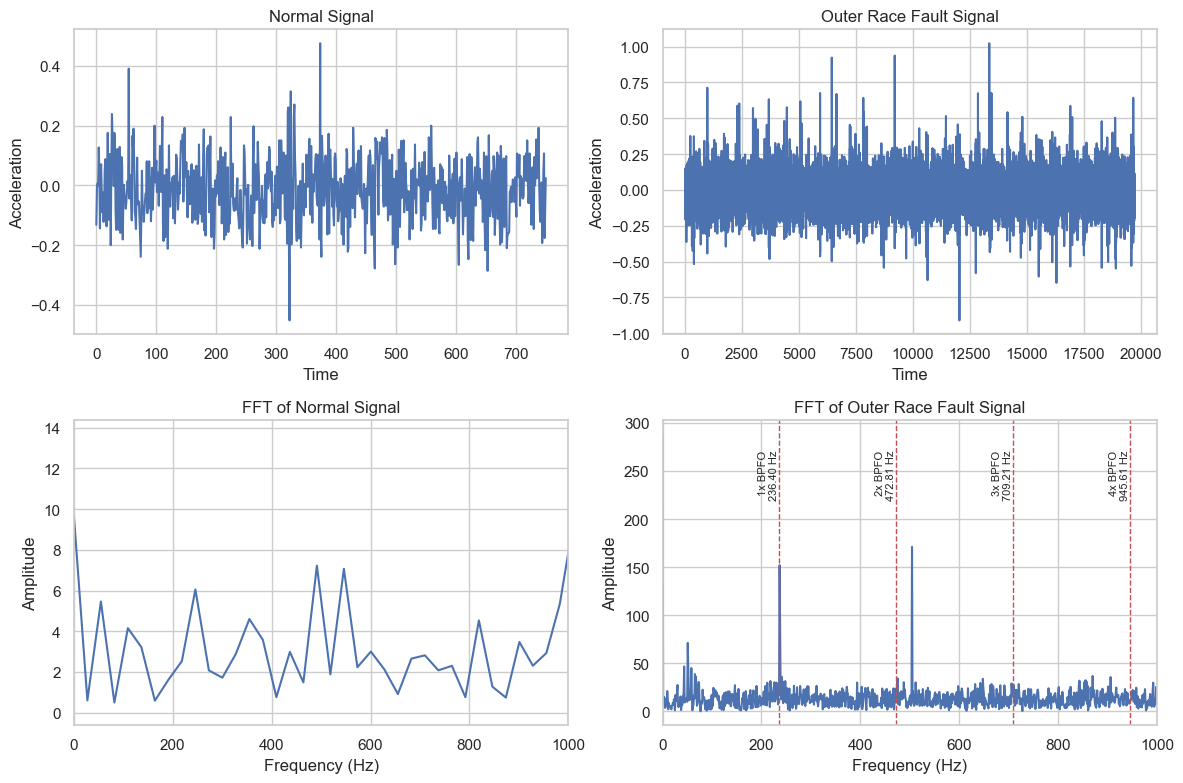

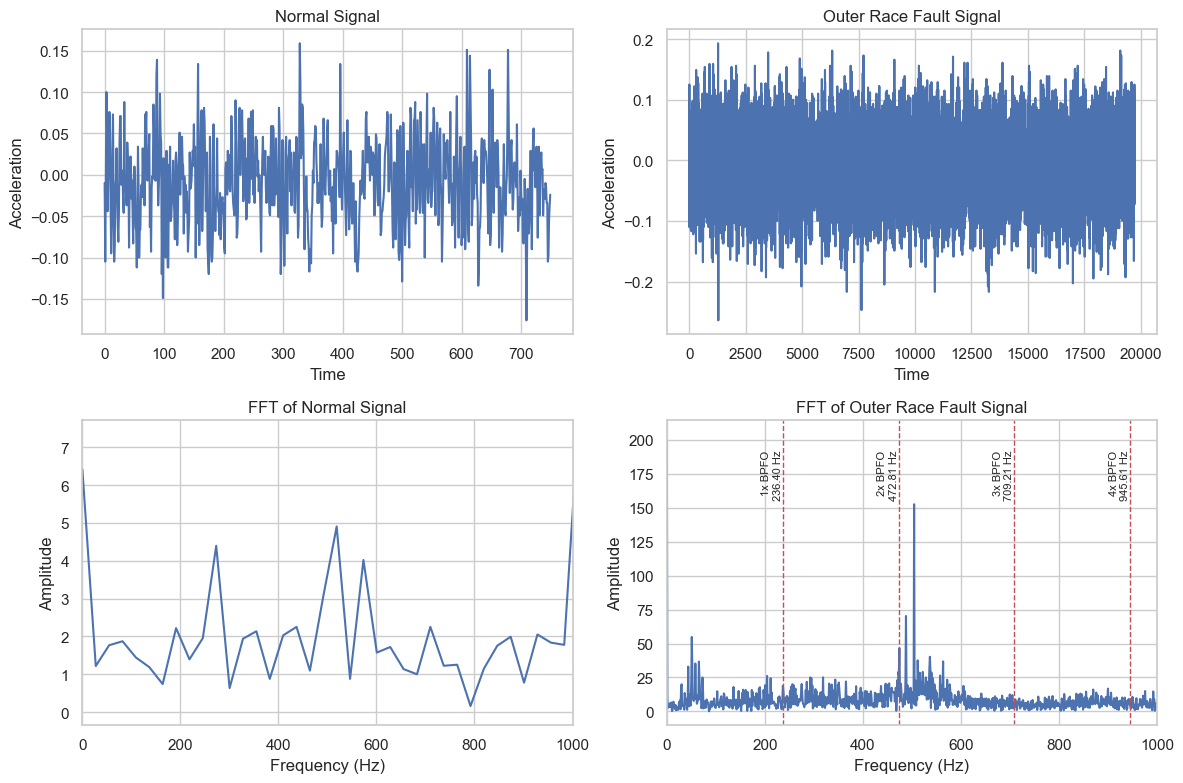

data dir path : C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/
length of files :  984
Reading file 1 of 984
Reading file 2 of 984
Reading file 3 of 984
Reading file 4 of 984
Reading file 5 of 984
Reading file 6 of 984
Reading file 7 of 984
Reading file 8 of 984
Reading file 9 of 984
Reading file 10 of 984
Reading file 11 of 984
Reading file 12 of 984
Reading file 13 of 984
Reading file 14 of 984
Reading file 15 of 984
Reading file 16 of 984
Reading file 17 of 984
Reading file 18 of 984
Reading file 19 of 984
Reading file 20 of 984
Reading file 21 of 984
Reading file 22 of 984
Reading file 23 of 984
Reading file 24 of 984
Reading file 25 of 984
Reading file 26 of 984
Reading file 27 of 984
Reading file 28 of 984
Reading file 29 of 984
Reading file 30 of 984
Reading file 31 of 984
Reading file 32 of 984
Reading file 33 of 984
Reading file 34 of 984
Reading file 35 of 984
Reading file 36 of 984
Reading file 37 of 984
Reading file 38 of 984
Reading file 39 of 984
Reading file 40 of

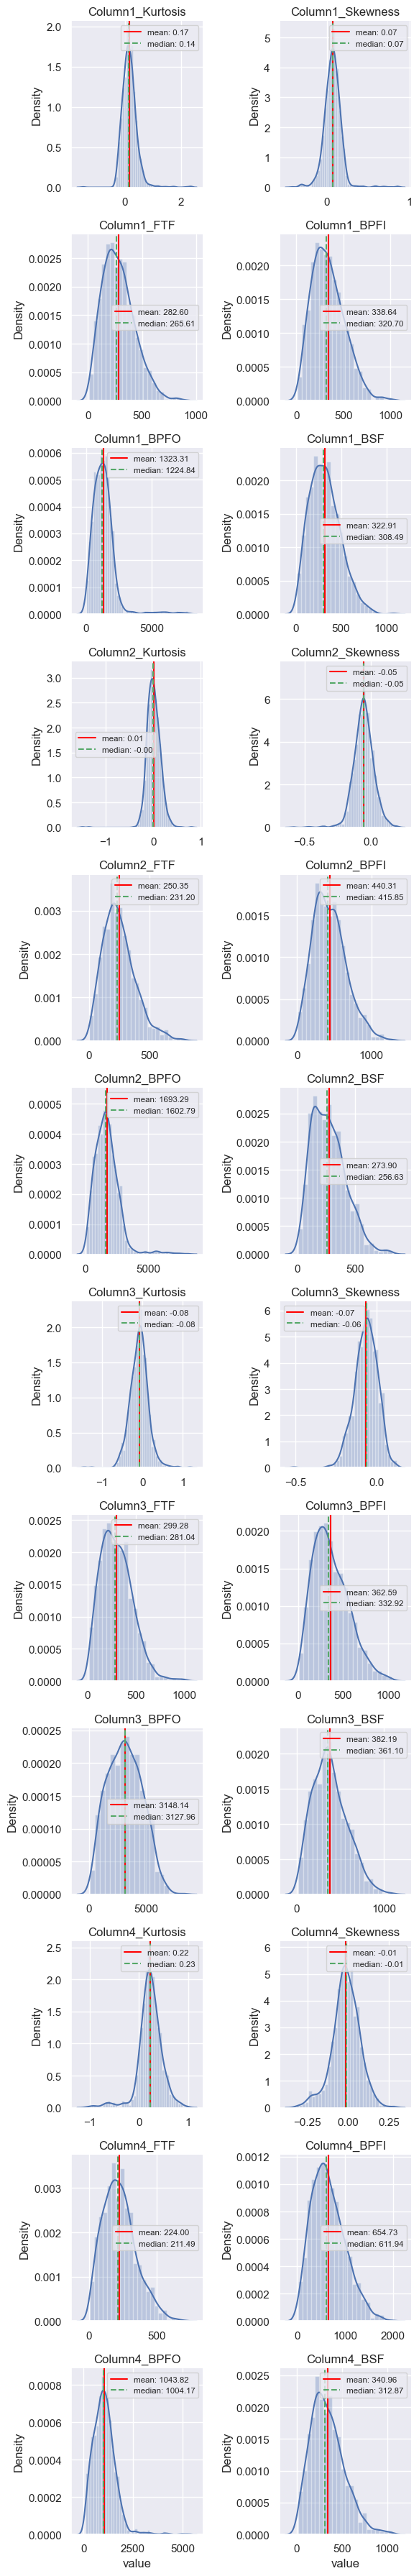

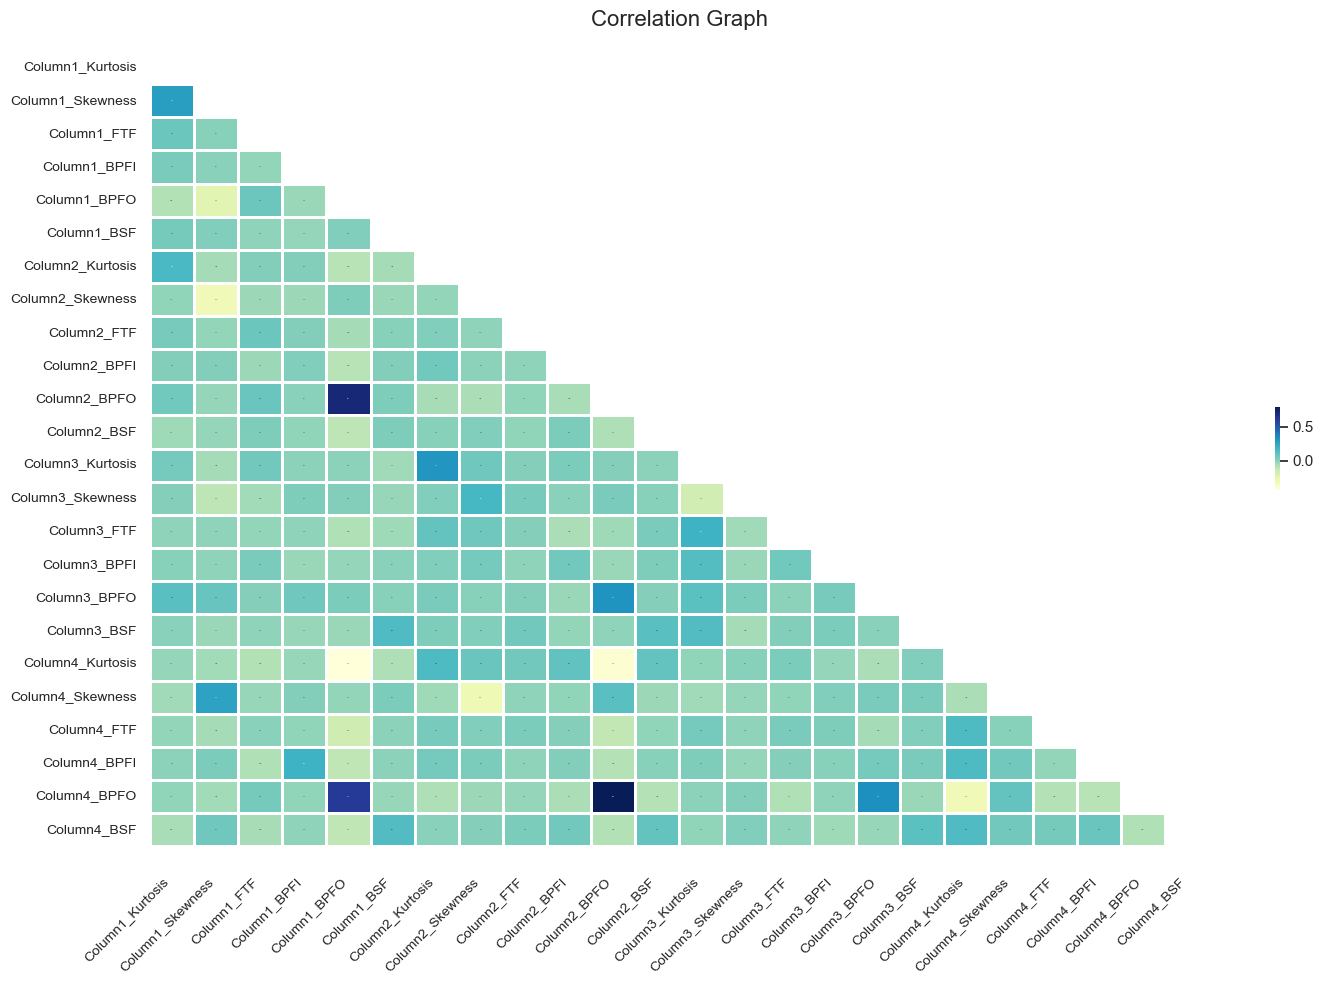

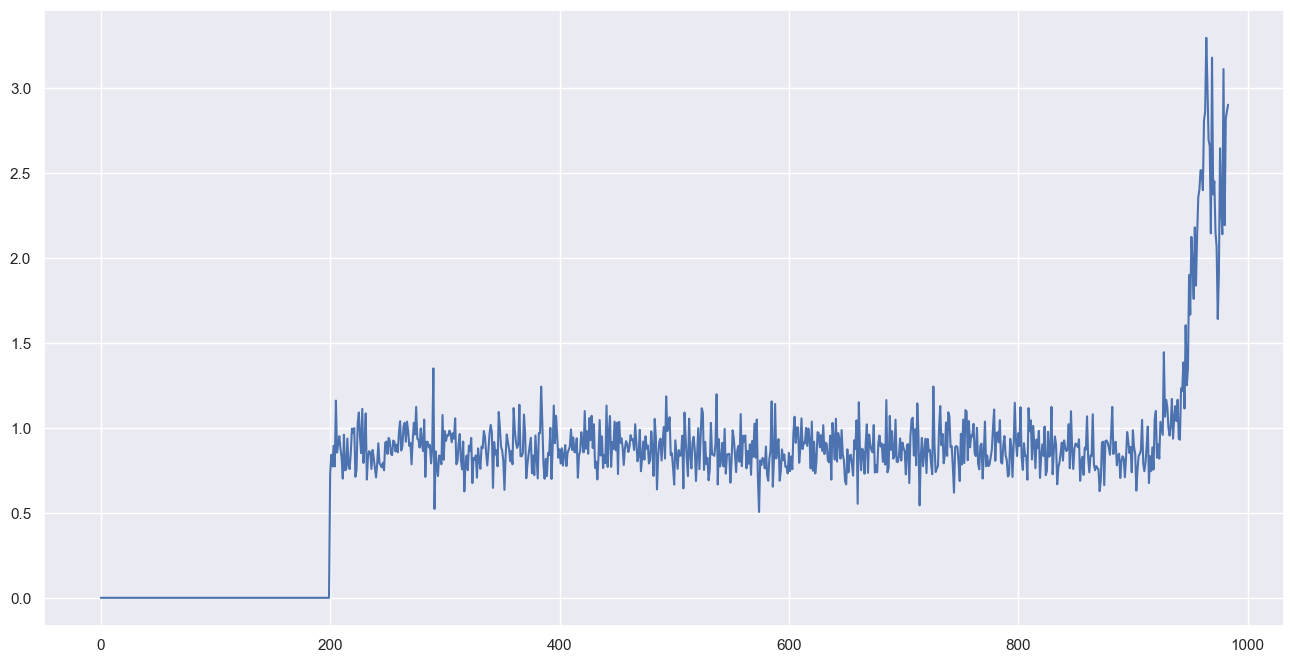

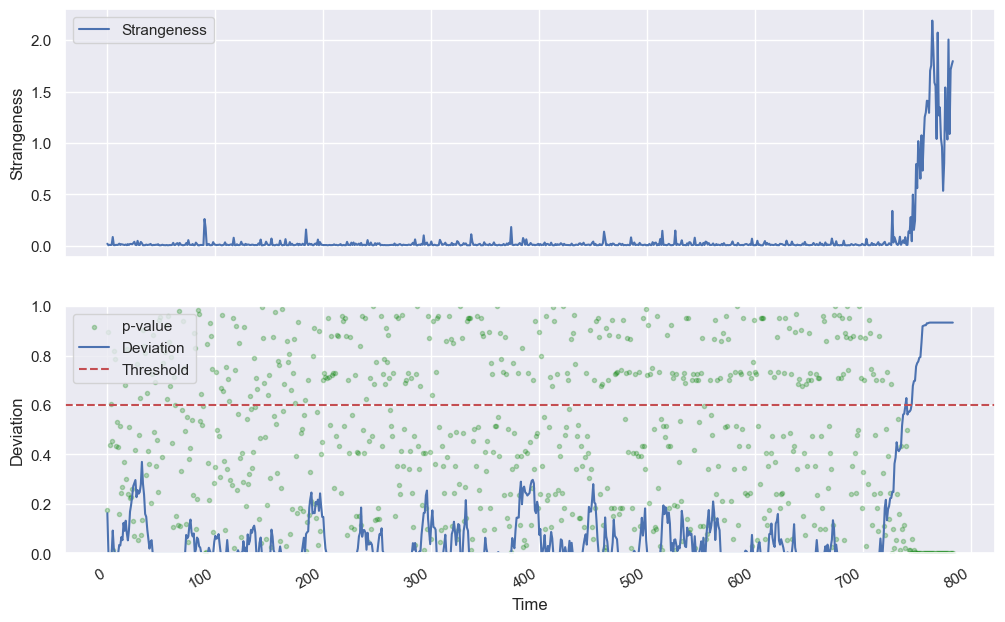

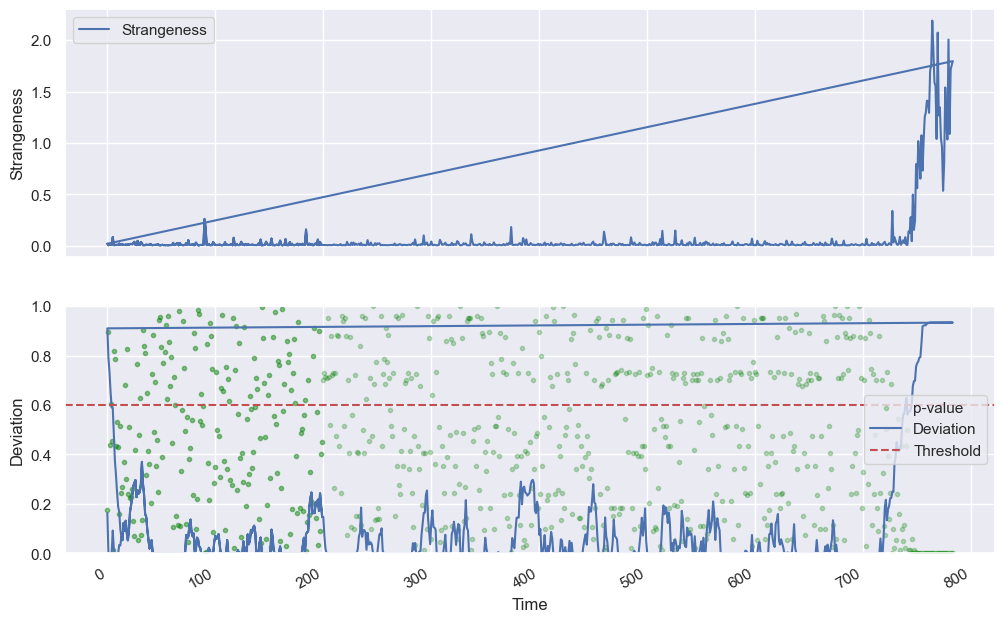

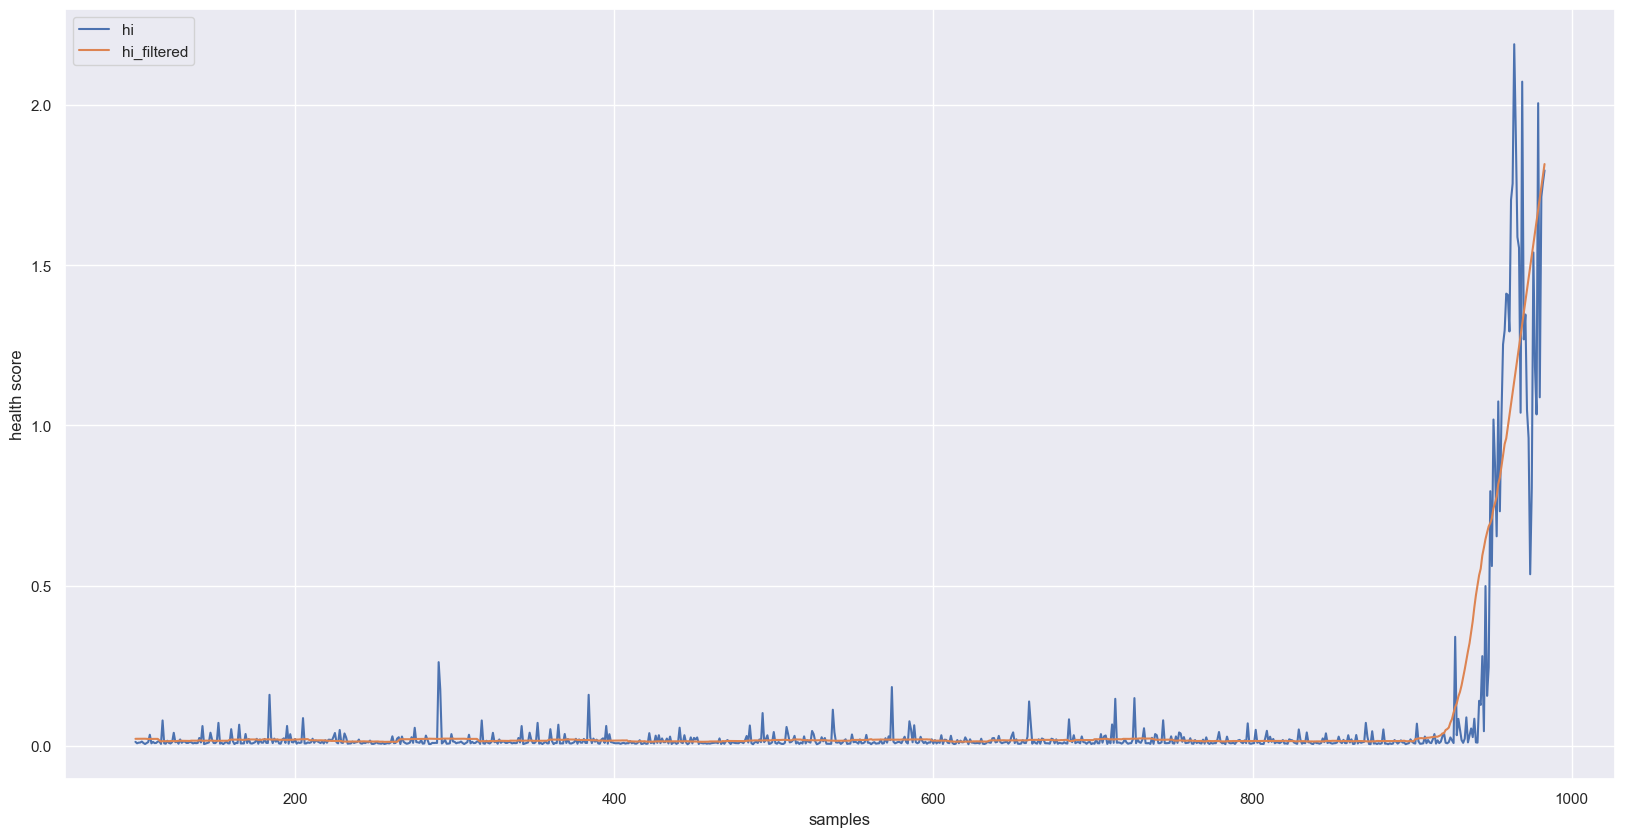

[0.00508647 0.02746694 0.00101729 0.00712106 0.01322482 0.00101729
 0.00915565 0.00508647 0.01525941 0.00101729 0.00915565 0.02543235
 0.00508647 0.01119023 0.017294   0.00305188 0.00508647 0.01322482
 0.00508647 0.02543235 0.00305188 0.00915565 0.02543235 0.00915565]
The health_score is : 1.7965591487946841 p value: 0.0 deviation : 0.9333333333333333
No degradation detected.


AttributeError: 'DataPreprocessing' object has no attribute 'savgol_filter'

In [3]:

import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.signal import butter, lfilter, savgol_filter, hilbert
#from scipy.stats import kurtosis
from scipy.fftpack import fft
from scipy.fft import fft, fftfreq
from scipy.signal import cwt, find_peaks_cwt, ricker
#from IntelliMaint.feature_engineering import TimeDomain
#from IntelliMaint.feature_engineering import FrequencyDomain
#from IntelliMaint.anomaly_detection import AnomalyDetection
from IntelliMaint.data_analysis import SOM
from IntelliMaint.rul_models import GPRDegradationModel
from IntelliMaint.preprocessing import DataPreprocessing
from IntelliMaint.eda import ExploratoryAnalysis
from IntelliMaint.health_assessment import HealthIndicator
#from IntelliMaint.Utils import Utils  # Import the Utils class

import pickle as pkl
from imblearn.over_sampling import SMOTE

import sys
sys.path.insert(0, r'C:\Users\DELL\Desktop\Template\IntelliMaint')

from data_acquistion import DataAcquisition
from feature_engineering import TimeDomain, FrequencyDomain
from anomaly_detection import AnomalyDetection



class Bearing: #model of bearing done from bearing diag
    def __init__(self, files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols):
        self.files = files
        self.Bd = Bd
        self.Pd = Pd
        self.Nb = Nb
        self.a = a
        self.s = s
        self.sampRate = sampRate
        self.ratio = self.Bd / self.Pd * math.cos(self.a)
        self.ftf = self.s / 2 * (1 - self.ratio)
        self.bpfi = self.Nb / 2 * self.s * (1 + self.ratio)
        self.bpfo = self.Nb / 2 * self.s * (1 - self.ratio)
        self.bsf = self.Pd / self.Bd * self.s / 2 * (1 - self.ratio**2)
        self.bearFreq = [self.ftf, self.bpfi, self.bpfo, self.bsf]
        self.ber = ber
        self.n_cols = n_cols

    def analyze_raw_data(self, n_cols):
        rawData = pd.read_csv(self.files[0], sep='\t', header=None)
        
        for Col in range(self.n_cols):
            signal = rawData.iloc[:, Col].values

            # Split the signal into normal and outer_fault portions
            normal_signal = signal[:750]
            outer_fault_signal = signal[750:]

            # Plot the normal and outer race fault signals
            plt.figure(figsize=(12, 8))
            plt.subplot(2, 2, 1)
            plt.plot(normal_signal)
            plt.title('Normal Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            plt.subplot(2, 2, 2)
            plt.plot(outer_fault_signal)
            plt.title('Outer Race Fault Signal')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')

            # Perform FFT on the normal and outer race fault signals
            normal_fft = np.abs(fft(normal_signal))
            outer_fault_fft = np.abs(fft(outer_fault_signal))
    
            freq_normal = np.fft.fftfreq(len(normal_signal), 1/self.sampRate)
            freq_outer_fault = np.fft.fftfreq(len(outer_fault_signal), 1/self.sampRate)
    
            # Plot the FFT of the normal signal
            plt.subplot(2, 2, 3)
            plt.plot(freq_normal[:len(freq_normal)//2], normal_fft[:len(normal_fft)//2])
            plt.title('FFT of Normal Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Plot the FFT of the outer race fault signal
            plt.subplot(2, 2, 4)
            plt.plot(freq_outer_fault[:len(freq_outer_fault)//2], outer_fault_fft[:len(outer_fault_fft)//2])
            plt.title('FFT of Outer Race Fault Signal')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.xlim(0, 1000)  # Adjust the frequency range as needed

            # Add vertical lines for BPFO harmonics in the outer race fault FFT plot
            num_harmonics = 4  # Number of harmonics to plot
            for i in range(1, num_harmonics + 1):
                harmonic_freq = i * self.bpfo
                plt.axvline(x=harmonic_freq, color='r', linestyle='--', linewidth=1, label=f'{i}x BPFO' if i == 1 else '')
                plt.text(harmonic_freq, plt.ylim()[1] * 0.9, f'{i}x BPFO\n{harmonic_freq:.2f} Hz', rotation=90, va='top', ha='right', fontsize=8)
    
            plt.tight_layout()
            plt.show()


    #def extract_time_domain_features(self, signal):
        #kurtosis_val = kurtosis(signal)
        #skewness_val = skew(signal)
        
        # Return kurtosis and skewness as the time-domain features
        #return [kurtosis_val, skewness_val]
        #features = TimeDomain.extract_features_streaming(pd.Series(signal))
        #return features

    #def extract_fft(self, signal):
        #return FrequencyDomain.extract_fft(signal)

    #def extract_domain_features(self, xf, amps):
        # Extract FTF, BPFI, BPFO, BSF as domain features
        #return FrequencyDomain.extract_domain_features(xf, amps)

    def extract_features(self, preprocessed_signal):
    # Create an instance of TimeDomain
        td = TimeDomain()

    # Extract only kurtosis and skewness for the given signal
    # Assuming preprocessed_signal is in a format suitable for processing (NumPy array or DataFrame)
        kurtosis_val = td.get_kurtosis(preprocessed_signal)
        skewness_val = td.get_skewness(preprocessed_signal)

    # Combine kurtosis and skewness into a tuple for time-domain features
        time_features = (kurtosis_val, skewness_val)

    # Extract FFT domain features using FrequencyDomain
        fd = FrequencyDomain(self.sampRate, self.ftf, self.bpfi, self.bpfo, self.bsf, preprocessed_signal)
        domain_features = fd.extract_features(preprocessed_signal)

    # Convert domain_features to a tuple if not already
        domain_features = tuple(domain_features)

    # Return the combined features (time domain + FFT domain)
        return time_features + domain_features



# Get data from the directory
data_dir_path = r'C:\Users\DELL\Desktop\Template\data\2nd_test\2nd_test/'
data_acquisition = DataAcquisition()


# Get list of files
files = DataAcquisition.get_file_list(data_dir_path)
print(f"Total files found: {len(files)}")

# Get list of files
# Call the class method directly on the class, not the object
#files = DataAcquisition.get_file_list(data_dir_path)

#files = data_acquistion.get_file_list()
#print(len(files))
#print("---")


# Get all CSV files from the folder
#files = sorted(glob.glob(folder_path + '200*'))  # Sort files to ensure chronological order

#folder_path = r'C:\Users\DELL\Desktop\Navtat\inteliMaint-main\inteliMaint-main\examples\data\2nd_test\2nd_test/'
#print(folder_path)
#files = glob.glob(folder_path + '200*')[:]
#print(len(files))

############################################
Bd = 0.331  # ball diameter, in inches
Pd = 2.815  # pitch diameter, in inches
Nb = 16  # number of rolling elements
a = 15.17 * math.pi / 180  # contact angle, in radians
s = 2000 / 60  # rotational frequency, in Hz
ber = 0 #Can add ber to get raw_data plot for all ber
n_cols = 4


ratio = Bd / Pd * math.cos(a)
ftf = s / 2 * (1 - ratio)
bpfi = Nb / 2 * s * (1 + ratio)
bpfo = Nb / 2 * s * (1 - ratio)
bsf = Pd / Bd * s / 2 * (1 - ratio**2)
bearFreq = [ftf, bpfi, bpfo, bsf]
sampRate = 20480  # Sampling rate, in Hz
##############################################

bearing = Bearing(files, Bd, Pd, Nb, a, s, sampRate, ber, n_cols) #Can add ber to get raw_data plot for all ber

###################################
# Analyze raw vibration data
ber = 0
n_cols = 4
bearing.analyze_raw_data(ber)
##################################

# Initialize Preprocessing
preprocessing = DataPreprocessing()
df = data_acquisition.get_data_from_dir(data_dir_path)

# Lists to store all features and timestamps
all_features = []
all_timestamps = []

# Process each file
for file_path in files:
    df = DataAcquisition.get_data_from_file(file_path)
    file_features = []
    for Col in range(n_cols):  # Iterate through each column (sensor)
    #rawData = pd.read_csv(df.files[0], sep='\t', header=None)
        signal = pd.to_numeric(df.iloc[:, Col], errors= 'coerce').dropna().values
        signal = np.array(signal, dtype=float)  # Convert to numpy array
        preprocessed_signal = preprocessing.preprocess(signal, operations=['filter', 'smooth', 'normalize'])

    
    # Plot the preprocessed signal (after preprocessing)
    #plt.figure(figsize=(10, 4))
    #plt.plot(preprocessed_signal, label=f'Preprocessed Signal - Sensor {Col+1}', color='orange')
    #plt.title(f'Preprocessed Signal - Sensor {Col+1}')
    #plt.xlabel('Sample Index')
    #plt.ylabel('Amplitude')
    #plt.legend()
    #plt.show()

        features = bearing.extract_features(preprocessed_signal)
        file_features.extend(features)

    # Append features and timestamps
    all_features.append(file_features)


time_domain_columns = ['Kurtosis', 'Skewness'] #to correct ValueError: 6 columns passed, passed data had 18 columns
domain_columns = ['FTF', 'BPFI', 'BPFO', 'BSF']
all_columns = time_domain_columns + domain_columns
num_features_per_column = len(time_domain_columns + domain_columns) #To verify not to get error in Number of column PASSED
sensor_columns = [f'Column{Col+1}_{feat}' for Col in range(n_cols) for feat in all_columns]
print(sensor_columns)  # Verify the number of columns
feature_df = pd.DataFrame(all_features, columns=sensor_columns)    

print("Feature DataFrame:\n", feature_df.head())

eda_results = ExploratoryAnalysis.perform_eda(feature_df)

# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)




# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som+normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

score_train = []
score_test = []

for i in range(hi_train.shape[0]):
    score_train.append(health_score_train[i])

for i in range(hi_test.shape[0]):
    score_test.append(health_score_test[i])

h_score = score_train + score_test
h_score = np.array(h_score)

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()




# Assuming you already have the data
# For example, if feature_df is the dataframe containing the features:
data = feature_df.values

# Initialize the HealthIndicator and Utils classes
health_indicator = HealthIndicator()
#utils = Utils()  # Instantiate the Utils class


health_scores = health_indicator.computeHIScore(data, method='mon')  # 'mon' can be replaced with the desired method

# Print or use the health_scores for further analysis
print(health_scores)


# Perform anomaly detection
incipient_fault_threshold = 0.6
normal_data_pts_som = 200
deg_start_idx, score_till_incipient, initial_deg_pts = anomaly_detection.detect_anomaly(incipient_fault_threshold, normal_data_pts_som, files, ber, n_cols, som, scaler_, data_analysis, anomaly_detection, mqe)

min_continuous_deg_pts = 10
score_till_incipient_filtered = preprocessing.apply_savgol_filter(score_till_incipient, 51, 1)
initial_deg_pts_filtered = preprocessing.apply_savgol_filter(initial_deg_pts, 3, 1)

plt.figure(figsize=(20,10))
plt.plot(score_till_incipient, label='data below threshold')
plt.plot(score_till_incipient_filtered, label='data below threshold filtered')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts, label='data above threshold')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts_filtered, label='data above threshold filtered')
plt.plot([incipient_fault_threshold for i in range(len(score_till_incipient))], linestyle='dashed', color='#ffff00')
plt.text(0, 0.55, "incipient fault threshold")
plt.ylabel('health_score')
plt.xlabel('samples')
plt.legend()
plt.show()

In [7]:

anomaly_detection = AnomalyDetection()

# Perform anomaly detection
incipient_fault_threshold = 0.6
normal_data_pts_som = 200
deg_start_idx, score_till_incipient, initial_deg_pts = anomaly_detection.detect_anomaly(incipient_fault_threshold, normal_data_pts_som, files, ber, n_cols, som, scaler_, data_analysis, anomaly_detection, mqe)

min_continuous_deg_pts = 10
score_till_incipient_filtered = preprocessing.savgol_filter(score_till_incipient, 51, 1)
initial_deg_pts_filtered = preprocessing.savgol_filter(initial_deg_pts, 3, 1)

plt.figure(figsize=(20,10))
plt.plot(score_till_incipient, label='data below threshold')
plt.plot(score_till_incipient_filtered, label='data below threshold filtered')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts, label='data above threshold')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts_filtered, label='data above threshold filtered')
plt.plot([incipient_fault_threshold for i in range(len(score_till_incipient))], linestyle='dashed', color='#ffff00')
plt.text(0, 0.55, "incipient fault threshold")
plt.ylabel('health_score')
plt.xlabel('samples')
plt.legend()
plt.show()

NameError: name 'AnomalyDetection' is not defined

In [1]:
# Initialize anomaly detection object
anomaly_detection = AnomalyDetection()


# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)




# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
incipient_fault_threshold = 0.6
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som+normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

score_train = []
score_test = []

for i in range(hi_train.shape[0]):
    score_train.append(health_score_train[i])

for i in range(hi_test.shape[0]):
    score_test.append(health_score_test[i])

h_score = score_train + score_test
h_score = np.array(h_score)

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()

# Perform anomaly detection
incipient_fault_threshold = 0.6
normal_data_pts_som = 200
deg_start_idx, score_till_incipient, initial_deg_pts = anomaly_detection.detect_anomaly(incipient_fault_threshold, normal_data_pts_som, files, ber, n_cols, som, scaler_, data_analysis, anomaly_detection, mqe)

min_continuous_deg_pts = 10
score_till_incipient_filtered = preprocessing.savgol_filter(score_till_incipient, 51, 1)
initial_deg_pts_filtered = preprocessing.savgol_filter(initial_deg_pts, 3, 1)

plt.figure(figsize=(20,10))
plt.plot(score_till_incipient, label='data below threshold')
plt.plot(score_till_incipient_filtered, label='data below threshold filtered')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts, label='data above threshold')
plt.plot([i for i in range(len(score_till_incipient) - min_continuous_deg_pts, len(score_till_incipient))], initial_deg_pts_filtered, label='data above threshold filtered')
plt.plot([incipient_fault_threshold for i in range(len(score_till_incipient))], linestyle='dashed', color='#ffff00')
plt.text(0, 0.55, "incipient fault threshold")
plt.ylabel('health_score')
plt.xlabel('samples')
plt.legend()
plt.show()

NameError: name 'AnomalyDetection' is not defined

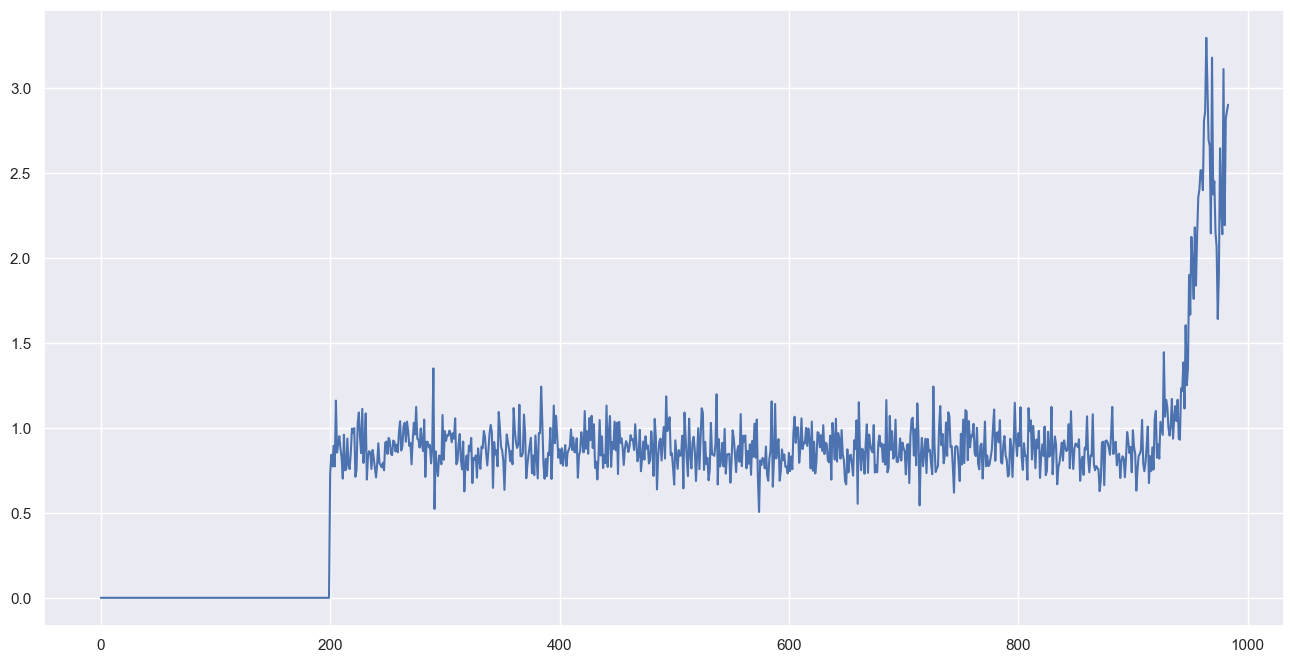

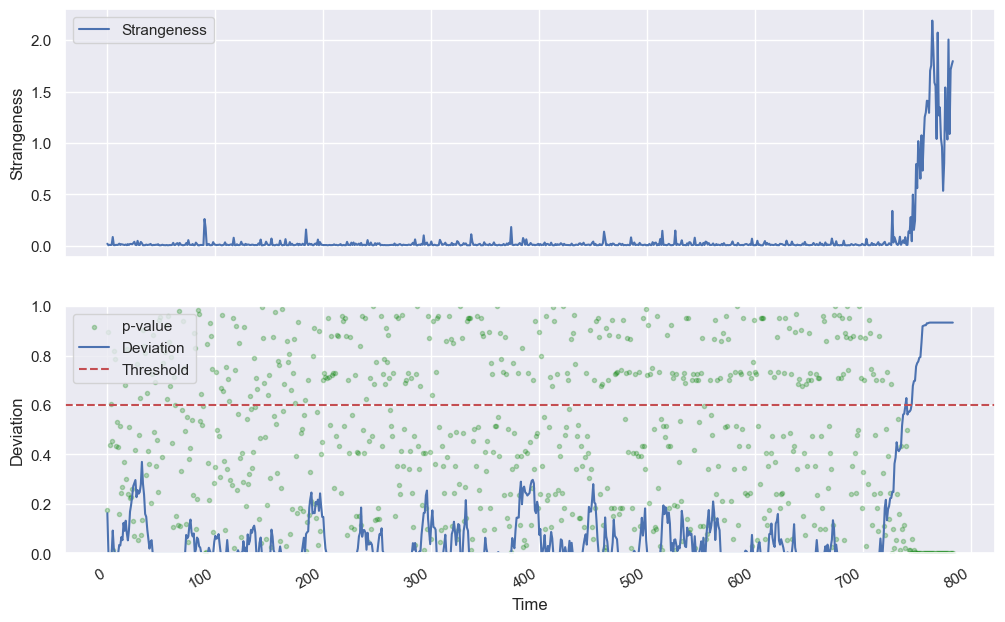

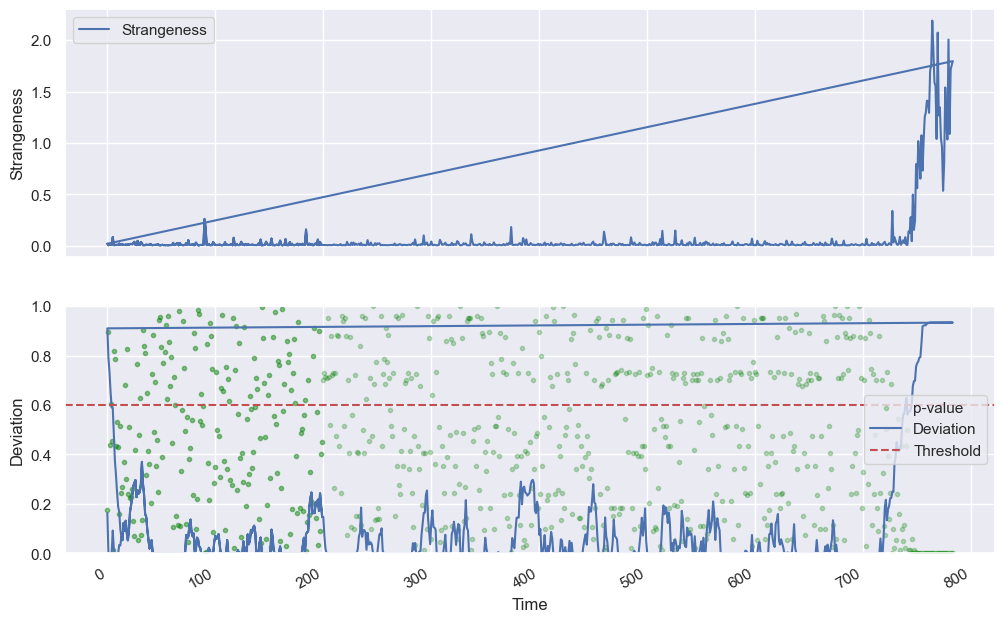

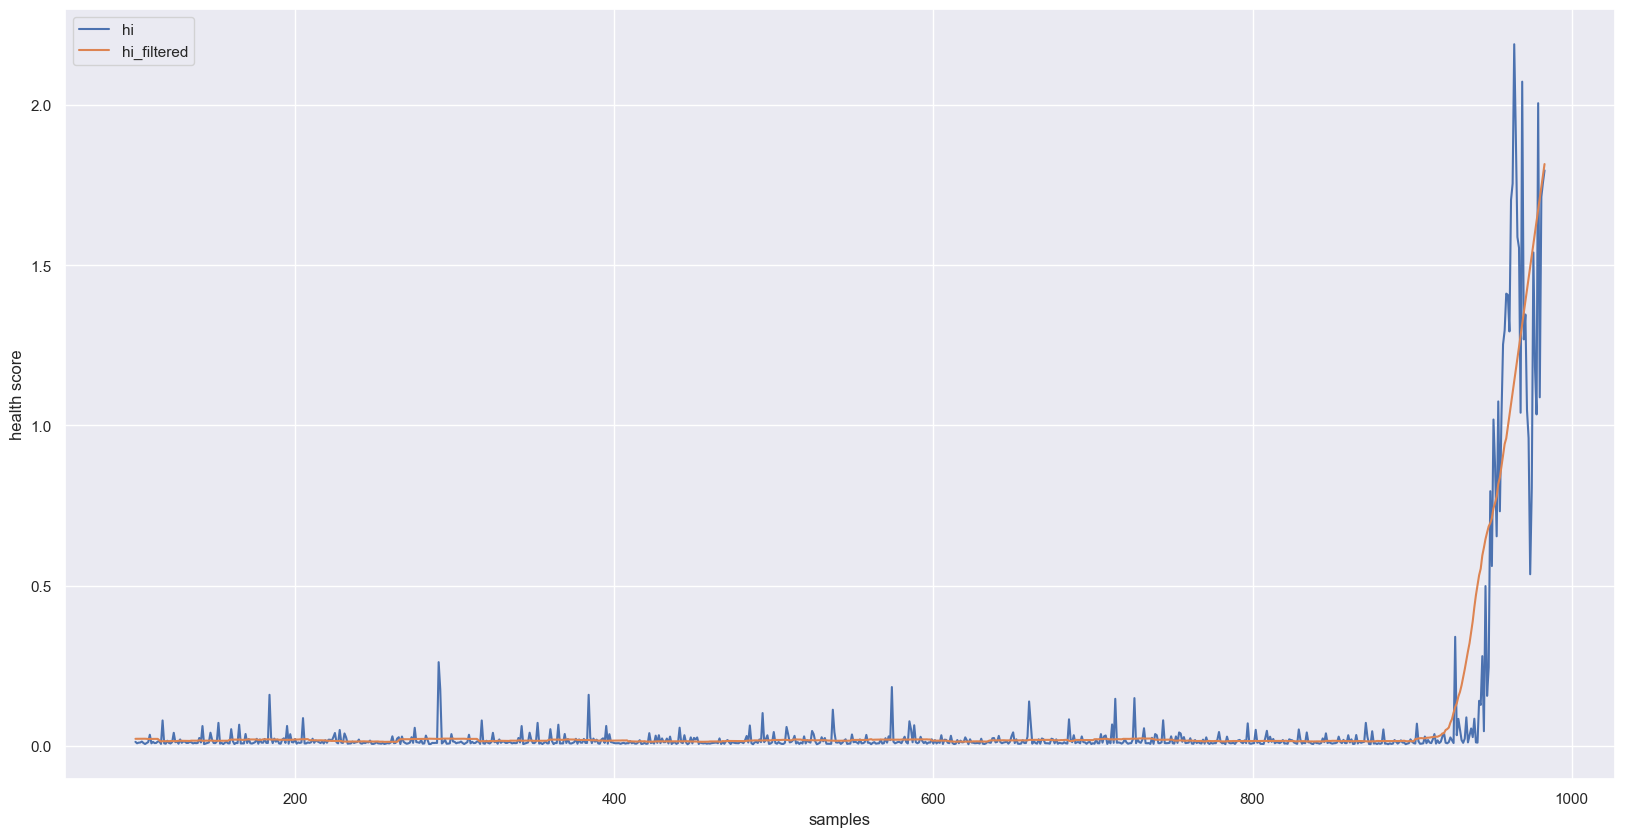

The health_score is : [0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808 0.68839808
 0.68839808 0.68839808 0.68839808 0.6883

In [48]:
# Initialize anomaly detection object
anomaly_detection = AnomalyDetection()


# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)




# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
incipient_fault_threshold = 0.6
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som+normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

score_train = []
score_test = []

for i in range(hi_train.shape[0]):
    score_train.append(health_score_train[i])

for i in range(hi_test.shape[0]):
    score_test.append(health_score_test[i])

h_score = score_train + score_test
h_score = np.array(h_score)

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()

error = pd.DataFrame(mqe)
health_score, p, deviation = anomaly_detection.test_cosmo_streaming(error)
health_score = health_score.squeeze()
            
#print("\rThe health_score is : {} p value: {} deviation : {}".format(health_score, p.squeeze(), deviation.squeeze()), end='')
last_health_score, last_p, last_deviation = health_scores[-1]

print("\rThe health_score is : {} p value: {} deviation : {}".format(last_health_score, last_p, last_deviation), end='')
# For streaming data processing
#health_score, p, deviation = anomaly_detection.test_cosmo_streaming(hi_test)

# Print health score, p-value, and deviation for streaming data
#print("\rThe health_score is: {} p-value: {} deviation: {}".format(
 #   health_score, p.squeeze(), deviation.squeeze()), end='')

# Track scores till incipient fault is detected
score_till_incipient = []
deg_start_idx = None
initial_deg_pts = []
score_till_incipient.append(health_score)

for i, health_score in enumerate(health_scores):  # Assuming there's a loop iterating over health scores
    if health_score >= incipient_fault_threshold:
        if not flag:
            deg_start_idx = i
        iter_ += 1

        if iter_ > 0:
            tracker += 1

            if tracker >= window_size:
                window_iter = iter_ - (tracker - window_size)
                window_tracker = window_size

                if window_iter / window_tracker >= 0.8:  # Adjust the ratio as needed
                    continuously_deg_pts += 1
                    initial_deg_pts.append(health_score)
                    flag = True  # Set flag to True when ratio condition is satisfied
                else:
                    initial_deg_pts = []
                    continuously_deg_pts = 0
                    iter_ = 0
                    tracker = 0
                    flag = False
                    deg_start_idx = None

            if continuously_deg_pts >= min_continuous_deg_pts:
                break  # Breaks out of the loop once degradation is detected

# After the loop ends, check the degradation index
if deg_start_idx is None:
    print("\nNo degradation detected.")
else:
    print("\nFound Degradation Start at instance... ", format(deg_start_idx))

#return deg_start_idx, score_till_incipient, initial_deg_pts



In [ ]:
# Initialize anomaly detection object
anomaly_detection = AnomalyDetection()

# Construct Health Indicator with SOM
normal_data_pts_som = 200
train_som = feature_df[:normal_data_pts_som]
test_som = feature_df
data_analysis = SOM()
som, scaler_ = data_analysis.train(train_som)
mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

plt.figure(figsize=(16, 8))
plt.plot(mqe)

# Train Anomaly detection with normal health indicator
normal_data_pts_cosmo = 200
incipient_fault_threshold = 0.6
hi = mqe

hi_train = hi[normal_data_pts_som:normal_data_pts_som + normal_data_pts_cosmo]
hi_test = hi[normal_data_pts_som:]
anomaly_detection = AnomalyDetection()
hi_train = pd.DataFrame(hi_train)
anomaly_detection.train_cosmo(hi_train)

# Evaluate health score using health indicator test
hi_test = pd.DataFrame(hi_test)
health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
health_score_test = health_score_test.squeeze()

hi_train = pd.DataFrame(hi_train)
health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
health_score_train = health_score_train.squeeze()

# Concatenate health scores for training and testing
h_score = np.concatenate([health_score_train, health_score_test])

window_length_filter = 50
h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)

plt.figure(figsize=(20, 10))
plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
plt.ylabel('health score')
plt.xlabel('samples')
plt.legend()
plt.show()

error = pd.DataFrame(mqe)

# Store results for streaming data
health_scores = []
for idx in range(len(error)):
    health_score, p, deviation = anomaly_detection.test_cosmo_streaming(error.iloc[idx:idx + 1])
    health_scores.append((health_score.squeeze(), p.squeeze(), deviation.squeeze()))

# Use only the last values for health_score, p, and deviation
last_health_score, last_p, last_deviation = health_scores[-1]

print("\rThe health_score is : {} p value: {} deviation : {}".format(last_health_score, last_p, last_deviation), end='')

# Track scores until incipient fault is detected
#score_till_incipient = []
#deg_start_idx = None
#initial_deg_pts = []


# Initialize necessary variables
score_till_incipient = []
deg_start_idx = None
initial_deg_pts = []
flag = False
iter_ = 0
tracker = 0
continuously_deg_pts = 0
min_continuous_deg_pts = 10
window_size = 70  # Adjust the window size as needed
score_till_incipient.append(last_health_score)

# Assuming there's a list of files available
for i in range(normal_data_pts_som + 1, len(files)):
    #df_ = self.extract_features(ber, n_cols, [files[i]], log_msg=False)

    #mqe = data_analysis.predict(som, df_, scaler_).reshape(-1, 1)
    error = pd.DataFrame(mqe)
    health_score, p, deviation = anomaly_detection.test_cosmo_streaming(error)
    health_score = health_score.squeeze()
            # Use only the last values for health_score, p, and deviation
    last_health_score, last_p, last_deviation = health_scores[-1]

    print("\rThe health_score is : {} p value: {} deviation : {}".format(last_health_score, last_p, last_deviation), end='')


    #print("\rThe health_score is : {} p value: {} deviation : {}".format(health_score, p.squeeze(), deviation.squeeze()), end='')
    score_till_incipient.append(health_score)

    # Check for incipient fault
    if (health_score >= incipient_fault_threshold).any():
        if deg_start_idx is None:  # If degradation has not started
            deg_start_idx = i
        iter_ += 1

    if iter_ > 0:
        tracker += 1

        if tracker >= window_size:
            window_iter = iter_ - (tracker - window_size)
            window_tracker = window_size

            if window_iter / window_tracker >= 0.8:  # Adjust the ratio as needed
                continuously_deg_pts += 1
                initial_deg_pts.append(health_score)
                flag = True  # Set flag to True when the ratio condition is satisfied
            else:
                initial_deg_pts.clear()
                continuously_deg_pts = 0
                iter_ = 0
                tracker = 0
                flag = False
                deg_start_idx = None

    if continuously_deg_pts >= min_continuous_deg_pts:
        break  # Breaks out of the loop once degradation is detected

# After the loop ends, check the degradation index
if deg_start_idx is None:
    print("\nNo degradation detected.")
else:
    print("\nFound Degradation Start at instance... ", format(deg_start_idx))

# Return the degradation start index, scores till incipient, and initial degradation points
return deg_start_idx, score_till_incipient, initial_deg_pts



In [46]:
def detect_degradation(feature_df, window_size=50, min_continuous_deg_pts=3):
    # Initialize anomaly detection object
    anomaly_detection = AnomalyDetection()

    # Construct Health Indicator with SOM
    normal_data_pts_som = 200
    train_som = feature_df[:normal_data_pts_som]
    test_som = feature_df
    data_analysis = SOM()
    som, scaler_ = data_analysis.train(train_som)
    mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

    plt.figure(figsize=(16, 8))
    plt.plot(mqe)
    plt.show()

    # Train Anomaly detection with normal health indicator
    normal_data_pts_cosmo = 200
    incipient_fault_threshold = 0.6
    hi = mqe

    hi_train = hi[normal_data_pts_som:normal_data_pts_som + normal_data_pts_cosmo]
    hi_test = hi[normal_data_pts_som:]
    anomaly_detection = AnomalyDetection()
    hi_train = pd.DataFrame(hi_train)
    anomaly_detection.train_cosmo(hi_train)

    # Evaluate health score using health indicator test
    hi_test = pd.DataFrame(hi_test)
    health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
    health_score_test = health_score_test.squeeze()

    hi_train = pd.DataFrame(hi_train)
    health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
    health_score_train = health_score_train.squeeze()

    score_train = []
    score_test = []

    for i in range(hi_train.shape[0]):
        score_train.append(health_score_train[i])

    for i in range(hi_test.shape[0]):
        score_test.append(health_score_test[i])

    h_score = score_train + score_test
    h_score = np.array(h_score)

    window_length_filter = 50
    h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
    plt.figure(figsize=(20, 10))
    plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
    plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
    plt.ylabel('health score')
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    error = pd.DataFrame(mqe)
    health_score, p, deviation = anomaly_detection.test_cosmo_streaming(error)
    health_score = health_score.squeeze()

    print("\rThe health_score is : {} p value: {} deviation : {}".format(health_score, p.squeeze(), deviation.squeeze()), end='')

    # Track scores till incipient fault is detected
    score_till_incipient = []
    deg_start_idx = None
    initial_deg_pts = []
    score_till_incipient.append(health_score)

    flag = False
    iter_ = 0
    tracker = 0
    continuously_deg_pts = 0

    for i, health_score in enumerate(h_score):  # Looping through health scores
        if health_score >= incipient_fault_threshold:
            if not flag:
                deg_start_idx = i
            iter_ += 1

            if iter_ > 0:
                tracker += 1

                if tracker >= window_size:
                    window_iter = iter_ - (tracker - window_size)
                    window_tracker = window_size

                    if window_iter / window_tracker >= 0.8:  # Adjust the ratio as needed
                        continuously_deg_pts += 1
                        initial_deg_pts.append(health_score)
                        flag = True  # Set flag to True when ratio condition is satisfied
                    else:
                        initial_deg_pts = []
                        continuously_deg_pts = 0
                        iter_ = 0
                        tracker = 0
                        flag = False
                        deg_start_idx = None

                if continuously_deg_pts >= min_continuous_deg_pts:
                    break  # Breaks out of the loop once degradation is detected

    # After the loop ends, check the degradation index
    if deg_start_idx is None:
        print("\nNo degradation detected.")
    else:
        print("\nFound Degradation Start at instance... ", format(deg_start_idx))

    return deg_start_idx, score_till_incipient, initial_deg_pts

# Example usage:
# deg_start_idx, score_till_incipient, initial_deg_pts = detect_degradation(feature_df)


In [1]:
# Assuming you already have the data
# For example, if feature_df is the dataframe containing the features:
from IntelliMaint.health_assessment import HealthIndicator


data = feature_df.values

# Initialize the HealthIndicator and Utils classes
health_indicator = HealthIndicator()


health_scores = health_indicator.computeHIScore(data, method='mon')  # 'mon' can be replaced with the desired method

# Print or use the health_scores for further analysis
print(health_scores)

NameError: name 'feature_df' is not defined

In [44]:
def detect_degradation(feature_df, window_size=50, min_continuous_deg_pts=3):
    # Initialize anomaly detection object
    anomaly_detection = AnomalyDetection()

    # Construct Health Indicator with SOM
    normal_data_pts_som = 200
    train_som = feature_df[:normal_data_pts_som]
    test_som = feature_df
    data_analysis = SOM()
    som, scaler_ = data_analysis.train(train_som)
    mqe = data_analysis.predict(som, test_som, scaler_).reshape(-1, 1)

    plt.figure(figsize=(16, 8))
    plt.plot(mqe)
    plt.show()

    # Train Anomaly detection with normal health indicator
    normal_data_pts_cosmo = 200
    incipient_fault_threshold = 0.6
    hi = mqe

    hi_train = hi[normal_data_pts_som:normal_data_pts_som + normal_data_pts_cosmo]
    hi_test = hi[normal_data_pts_som:]
    anomaly_detection = AnomalyDetection()
    hi_train = pd.DataFrame(hi_train)
    anomaly_detection.train_cosmo(hi_train)

    # Evaluate health score using health indicator test
    hi_test = pd.DataFrame(hi_test)
    health_score_test, _ = anomaly_detection.test_cosmo(hi_test)
    health_score_test = health_score_test.squeeze()

    hi_train = pd.DataFrame(hi_train)
    health_score_train, _ = anomaly_detection.test_cosmo(hi_train)
    health_score_train = health_score_train.squeeze()

    score_train = []
    score_test = []

    for i in range(hi_train.shape[0]):
        score_train.append(health_score_train[i])

    for i in range(hi_test.shape[0]):
        score_test.append(health_score_test[i])

    h_score = score_train + score_test
    h_score = np.array(h_score)

    window_length_filter = 50
    h_score_filtered = preprocessing.apply_savgol_filter(h_score, window_length_filter, 1)
    plt.figure(figsize=(20, 10))
    plt.plot([i for i in range(100, h_score.shape[0])], h_score[100:h_score.shape[0]], label='hi')
    plt.plot([i for i in range(100, h_score.shape[0])], h_score_filtered[100:h_score.shape[0]], label='hi_filtered')
    plt.ylabel('health score')
    plt.xlabel('samples')
    plt.legend()
    plt.show()

    error = pd.DataFrame(mqe)
    health_score, p, deviation = anomaly_detection.test_cosmo_streaming(error)
    health_score = health_score.squeeze()

    print("\rThe health_score is : {} p value: {} deviation : {}".format(health_score, p.squeeze(), deviation.squeeze()), end='')

    # Track scores till incipient fault is detected
    score_till_incipient = []
    deg_start_idx = None
    initial_deg_pts = []
    score_till_incipient.append(health_score)

    flag = False
    iter_ = 0
    tracker = 0
    continuously_deg_pts = 0

    for i, health_score in enumerate(h_score):  # Looping through health scores
        if health_score >= incipient_fault_threshold:
            if not flag:
                deg_start_idx = i
            iter_ += 1

            if iter_ > 0:
                tracker += 1

                if tracker >= window_size:
                    window_iter = iter_ - (tracker - window_size)
                    window_tracker = window_size

                    if window_iter / window_tracker >= 0.8:  # Adjust the ratio as needed
                        continuously_deg_pts += 1
                        initial_deg_pts.append(health_score)
                        flag = True  # Set flag to True when ratio condition is satisfied
                    else:
                        initial_deg_pts = []
                        continuously_deg_pts = 0
                        iter_ = 0
                        tracker = 0
                        flag = False
                        deg_start_idx = None

                if continuously_deg_pts >= min_continuous_deg_pts:
                    break  # Breaks out of the loop once degradation is detected

    # After the loop ends, check the degradation index
    if deg_start_idx is None:
        print("\nNo degradation detected.")
    else:
        print("\nFound Degradation Start at instance... ", format(deg_start_idx))

    return deg_start_idx, score_till_incipient, initial_deg_pts

# Example usage:
# deg_start_idx, score_till_incipient, initial_deg_pts = detect_degradation(feature_df)


In [108]:
import scipy
print(scipy.__version__)



1.12.0
